#  <a name="1">**Rossmann Store Sales Time Series Analysis** </a>

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances,

## Approach

1. Perform Analysis of the data related to this competition
2. Apply simple Forecasting models and use the same evaluation from the competition.
3. Apply ETS models (not all models explained, the one that you can see is suitable)
4. Apply the Arima model
5. Apply Prophet
6. Apply any machine learning of your choice
7. Choose the best among them and perform future forecasting on the test set and submit on Kaggle and add the


In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from lightgbm import LGBMRegressor
from prophet import Prophet
#logging.getLogger("cmdstanpy").disabled = True
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
plt.rcParams['figure.figsize'] = 25, 8



c:\Users\EL-Huda\AppData\Local\Programs\Python\Python39\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Load Data

In [2]:
train_df=pd.read_csv('train.csv')
store_df=pd.read_csv('store.csv')
test=pd.read_csv('test.csv')

train=train_df.merge(store_df,on='Store')
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

### about data

1. **Id** - an Id that represents a (Store, Date) duple within the test set
2. **Store** - a unique Id for each store
3. **Sales** - the turnover for any given day (this is what you are predicting)
4. **Customers** - the number of customers on a given day
5. **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
6. **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
7. **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
8. **StoreType** - differentiates between 4 different store models: a, b, c, d
9. **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
10. **CompetitionDistance** - distance in meters to the nearest competitor store
11. **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
12. **Promo** - indicates whether a store is running a promo on that day
13. **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
14. **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
15. **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Data Exploration and analysis

In [3]:
# shape data
print("shape train data",train.shape)
print("shape test data",test.shape)

shape train data (1017209, 18)
shape test data (41088, 8)


check null values

In [4]:
# check null values
train.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [5]:
## fill null values
train['CompetitionDistance'].fillna(train['CompetitionDistance'].median(),inplace=True)

In [6]:
train.fillna(0,inplace=True)
train.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [7]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [8]:
#fill null in test with one considering that store open
test.fillna(1,inplace=True)
test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

check data types

In [9]:
#data types
train.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
train['Date']=pd.to_datetime(train['Date'])
train['Date'].dtype

dtype('<M8[ns]')

In [11]:
train['day']=train['Date'].dt.day
train['month']=train['Date'].dt.month
train['year']=train['Date'].dt.year

In [12]:
train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType  ... CompetitionDistance  \
0              1         c  ...              1270.0   
1              1         a  ...               570.0   
2              1         a  ...             14130.0   
3              1         c  ...               620.0   
4              1         a  ...             29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval day  month  year  
0              0.0              0.0                0  31      7  2015  
1             13.0           2010.0  Jan,Apr,Jul,Oct  31      7  2015  
2             14.0           2011.0  Jan,Apr,Jul,Oct  31      7  2015  
3              0.0              0.0                0  31      7  2015  
4              0.0              0.0                0  31      7  2015  

[5 rows x 21 columns]

### Data Descriptive Info

In [13]:
train.describe()

Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06                        1017209   
mean   5.584297e+02  3.998341e+00  2014-04-11 01:30:42.846061824   
min    1.000000e+00  1.000000e+00            2013-01-01 00:00:00   
25%    2.800000e+02  2.000000e+00            2013-08-17 00:00:00   
50%    5.580000e+02  4.000000e+00            2014-04-02 00:00:00   
75%    8.380000e+02  6.000000e+00            2014-12-12 00:00:00   
max    1.115000e+03  7.000000e+00            2015-07-31 00:00:00   
std    3.219087e+02  1.997391e+00                            NaN   

              Sales     Customers          Open         Promo  SchoolHoliday  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06   
mean   5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00   
50%    5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00   
75%    7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00   
max    4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00   
std    3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01   

       CompetitionDistance  CompetitionOpenSinceMonth  \
count         1.017209e+06               1.017209e+06   
mean          5.422034e+03               4.926878e+00   
min           2.000000e+01               0.000000e+00   
25%           7.100000e+02               0.000000e+00   
50%           2.330000e+03               4.000000e+00   
75%           6.880000e+03               9.000000e+00   
max           7.586000e+04               1.200000e+01   
std           7.706913e+03               4.283543e+00   

       CompetitionOpenSinceYear        Promo2  Promo2SinceWeek  \
count              1.017209e+06  1.017209e+06     1.017209e+06   
mean               1.370173e+03  5.005638e-01     1.164767e+01   
min                0.000000e+00  0.000000e+00     0.000000e+00   
25%                0.000000e+00  0.000000e+00     0.000000e+00   
50%                2.006000e+03  1.000000e+00     1.000000e+00   
75%                2.011000e+03  1.000000e+00     2.200000e+01   
max                2.015000e+03  1.000000e+00     5.000000e+01   
std                9.353634e+02  4.999999e-01     1.532393e+01   

       Promo2SinceYear           day         month          year  
count     1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  
mean      1.007011e+03  1.570279e+01  5.846762e+00  2.013832e+03  
min       0.000000e+00  1.000000e+00  1.000000e+00  2.013000e+03  
25%       0.000000e+00  8.000000e+00  3.000000e+00  2.013000e+03  
50%       2.009000e+03  1.600000e+01  6.000000e+00  2.014000e+03  
75%       2.012000e+03  2.300000e+01  8.000000e+00  2.014000e+03  
max       2.015000e+03  3.100000e+01  1.200000e+01  2.015000e+03  
std       1.005877e+03  8.787638e+00  3.326097e+00  7.773960e-01

In [14]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)

Customers       Sales  SalesPerCustomer
StoreType                                         
a          363541434  3165334859      4.043129e+06
d          156904995  1765392943      2.918350e+06
c           92129705   783221426      9.744876e+05
b           31465621   159231395      7.987612e+04

Distribution of categorical columns

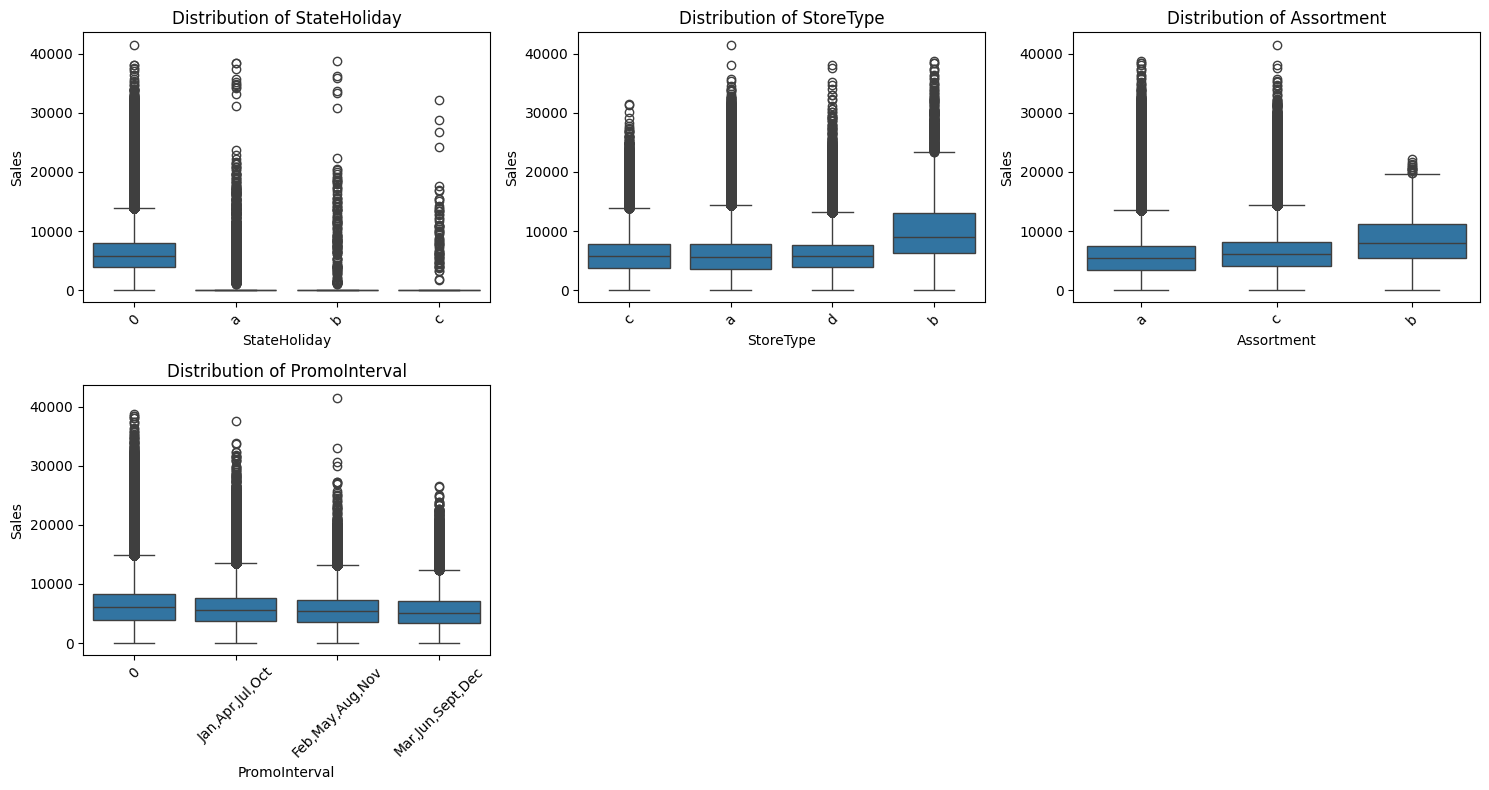

In [ ]:
cat_cols = train.select_dtypes(include='object').columns

total_plots = len(cat_cols) 
cols = 3  
rows = (total_plots + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))


for i, col in enumerate(cat_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=train[col],y=train['Sales'])
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')


plt.tight_layout()
plt.show()

Distribution of Numerical columns

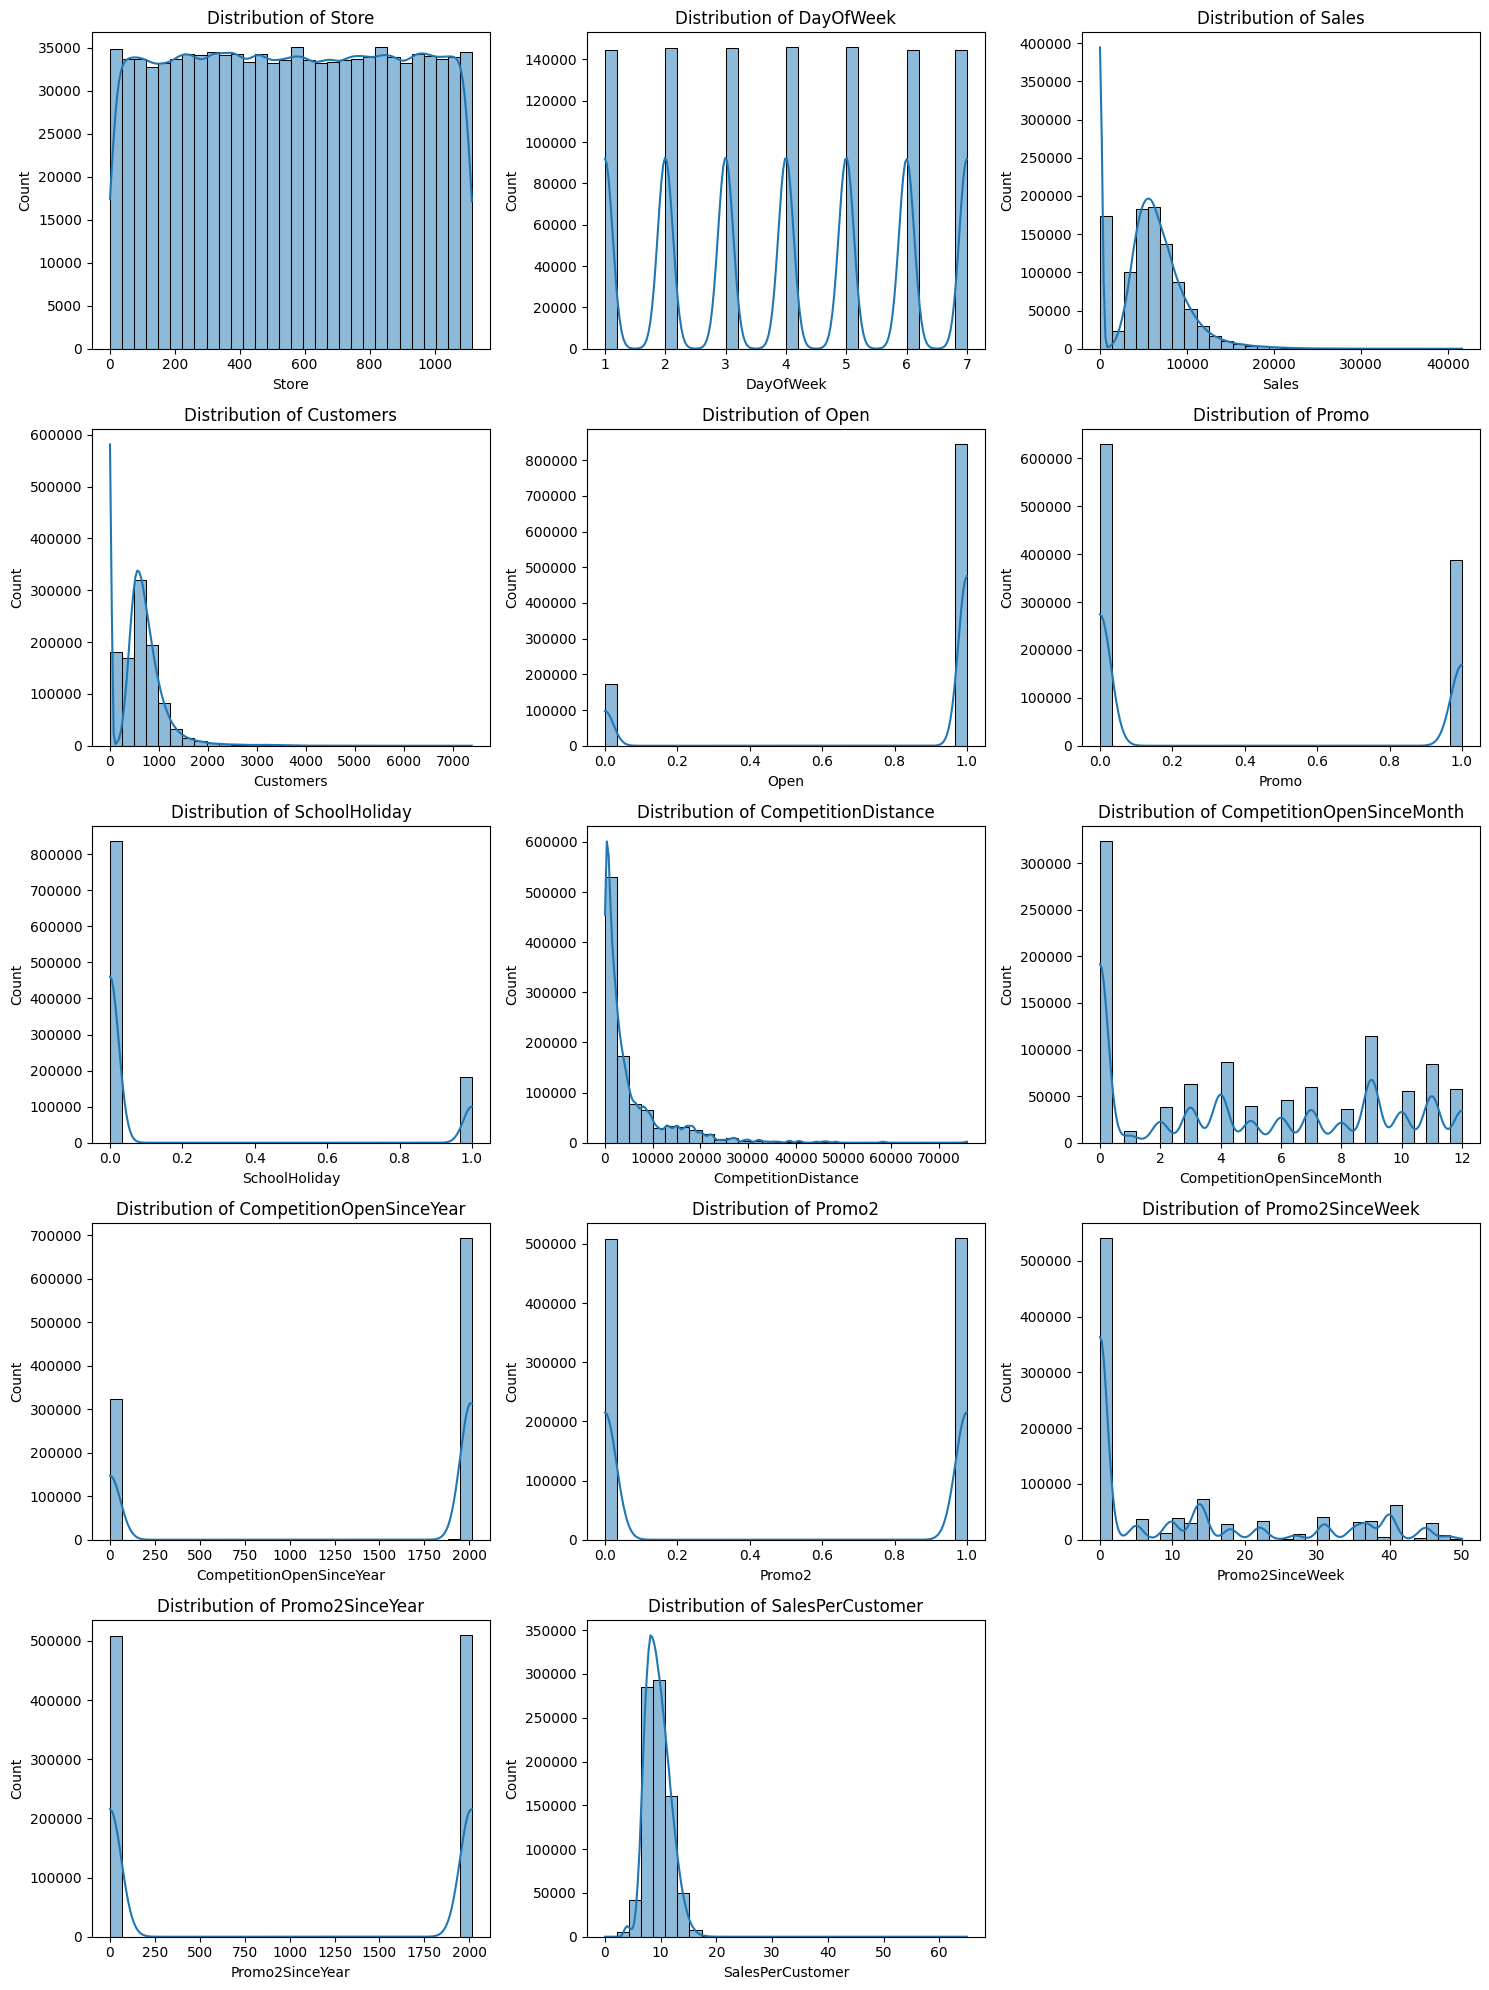

In [16]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

total_plots = len(num_cols)
cols = 3  # Number of plots per row
rows = (total_plots + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))

for j, col in enumerate(num_cols):
    plt.subplot(rows, cols, j + 1)  
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

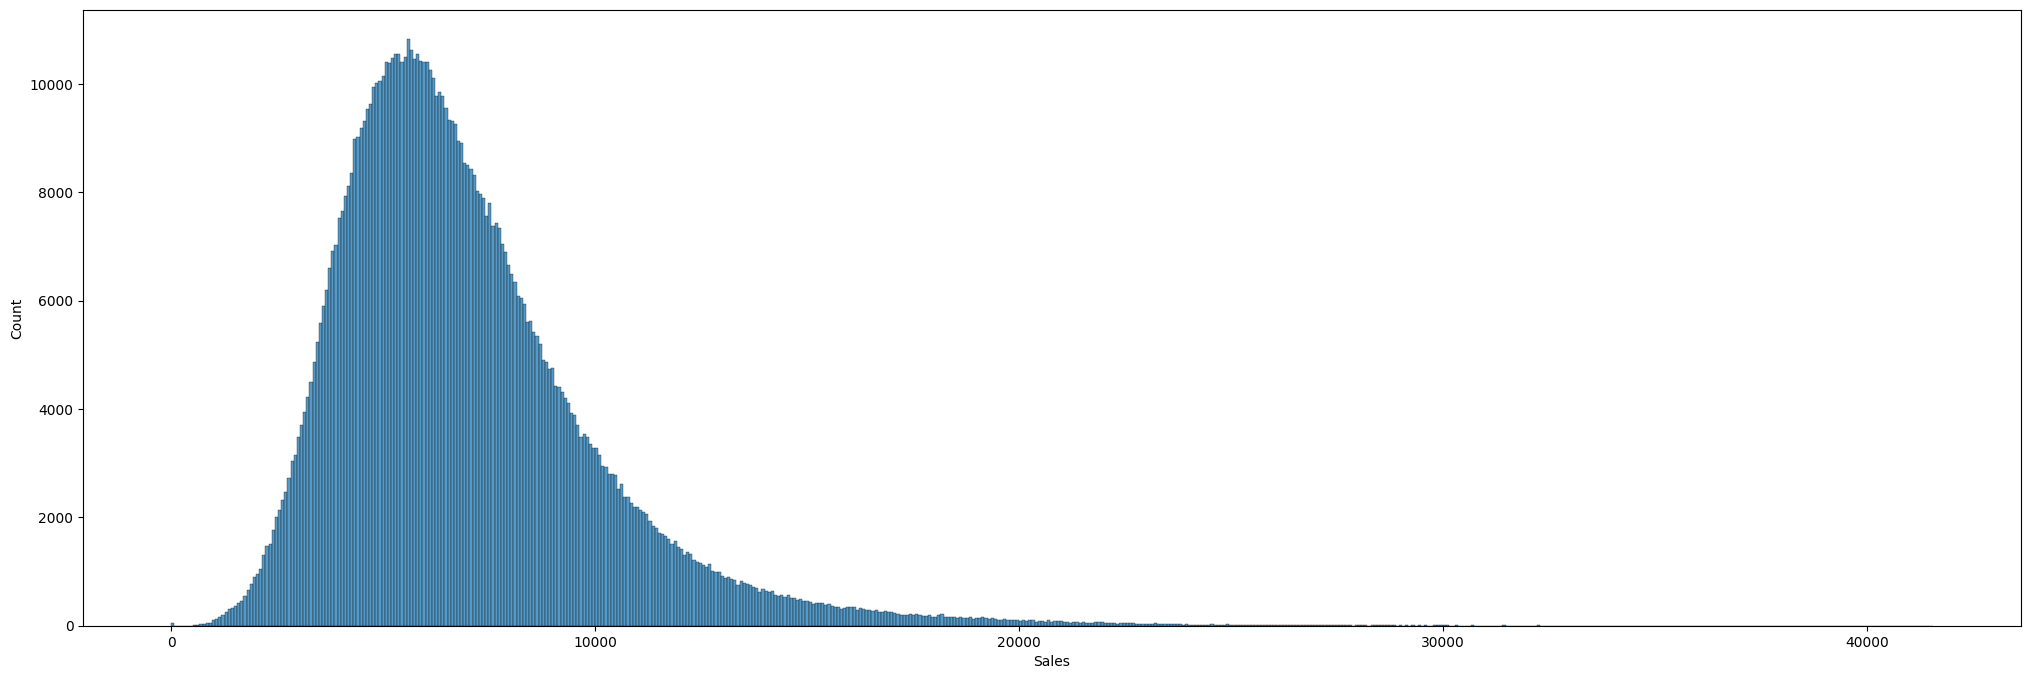

In [ ]:
sns.histplot(train[train['Open']==1 ]['Sales'])
plt.show

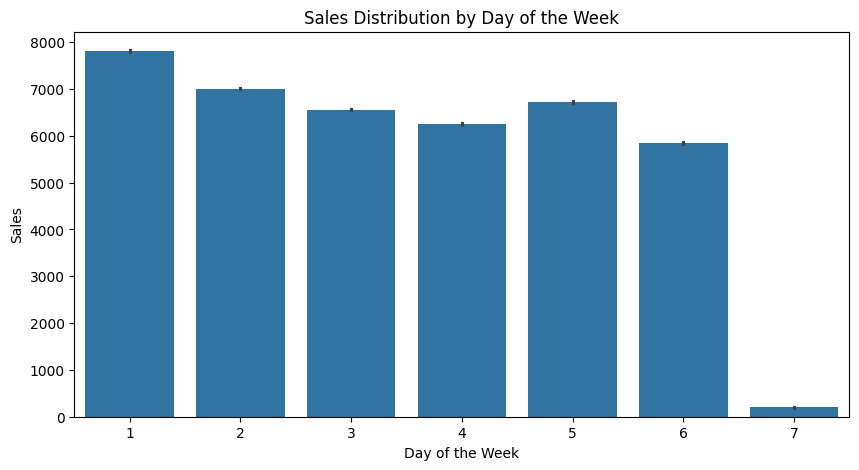

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=train, x='DayOfWeek', y='Sales')
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()

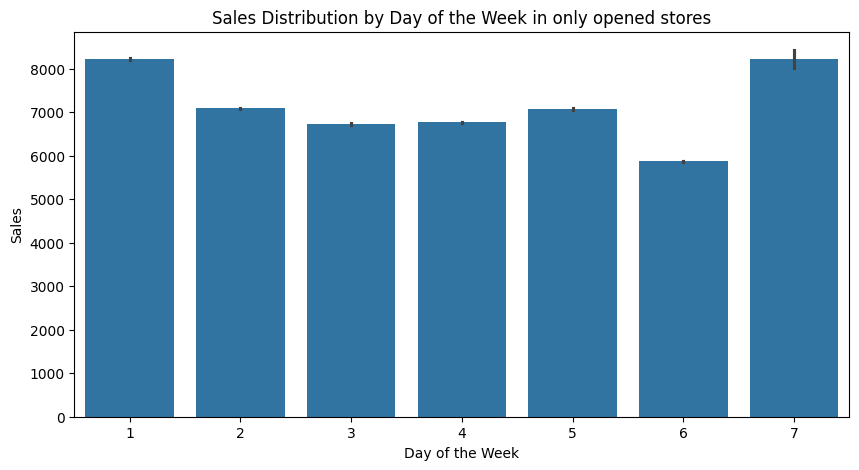

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(data=train[train['Open']==1], x='DayOfWeek', y='Sales')
plt.title('Sales Distribution by Day of the Week in only opened stores' )
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()

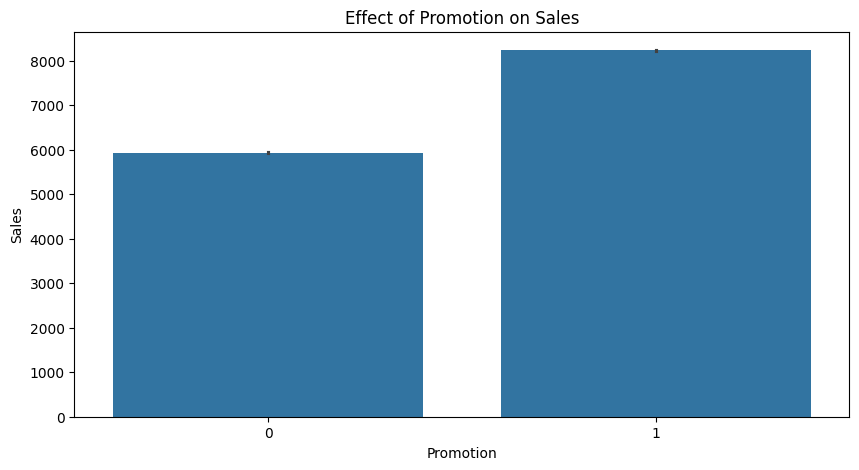

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=train[train['Sales'] > 0], x='Promo', y='Sales')
plt.title('Effect of Promotion on Sales')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()


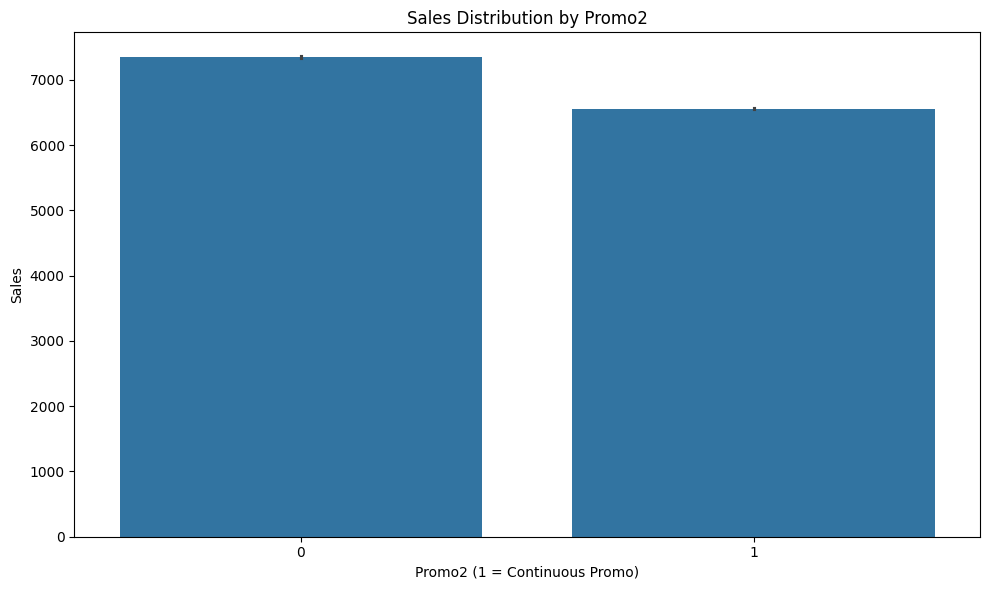

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=train[train['Sales'] > 0], x='Promo2', y='Sales')
plt.title('Sales Distribution by Promo2')
plt.xlabel('Promo2 (1 = Continuous Promo)')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

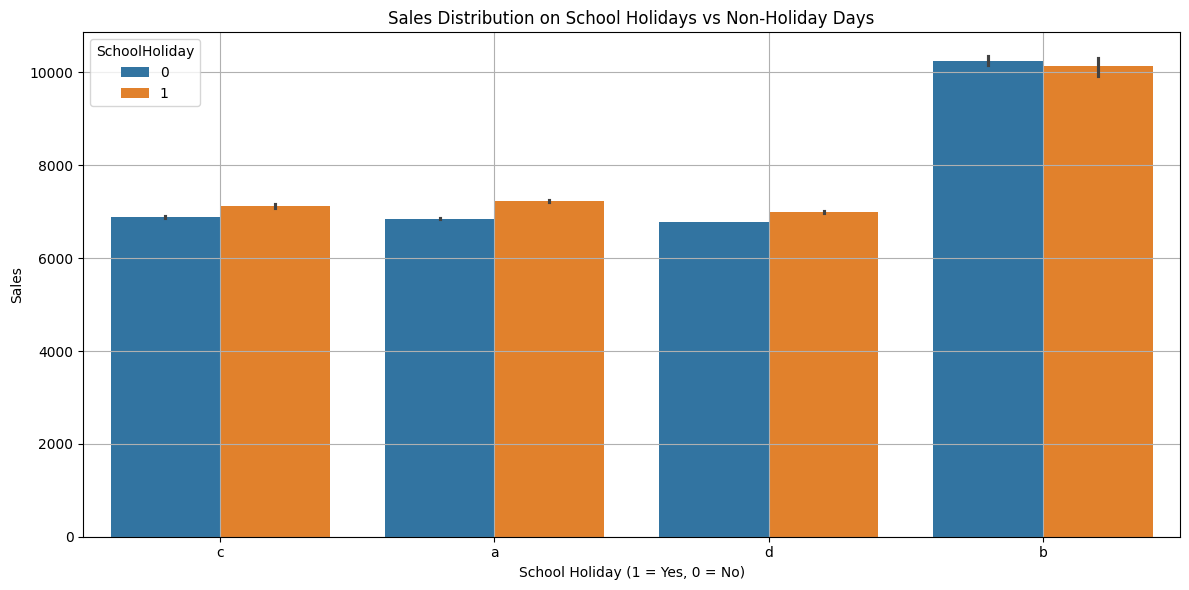

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=train[train['Sales'] > 0], x='StoreType', y='Sales',hue='SchoolHoliday')
plt.title('Sales Distribution on School Holidays vs Non-Holiday Days')
plt.xlabel('School Holiday (1 = Yes, 0 = No)')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

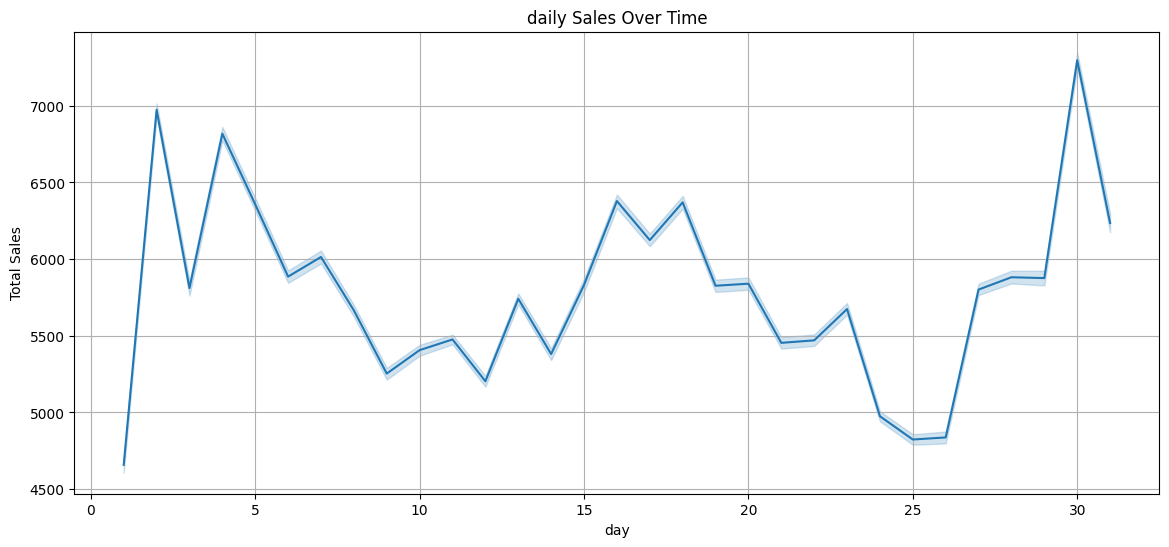

In [23]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=train,x='day',y='Sales')
plt.title('daily Sales Over Time')
plt.xlabel('day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

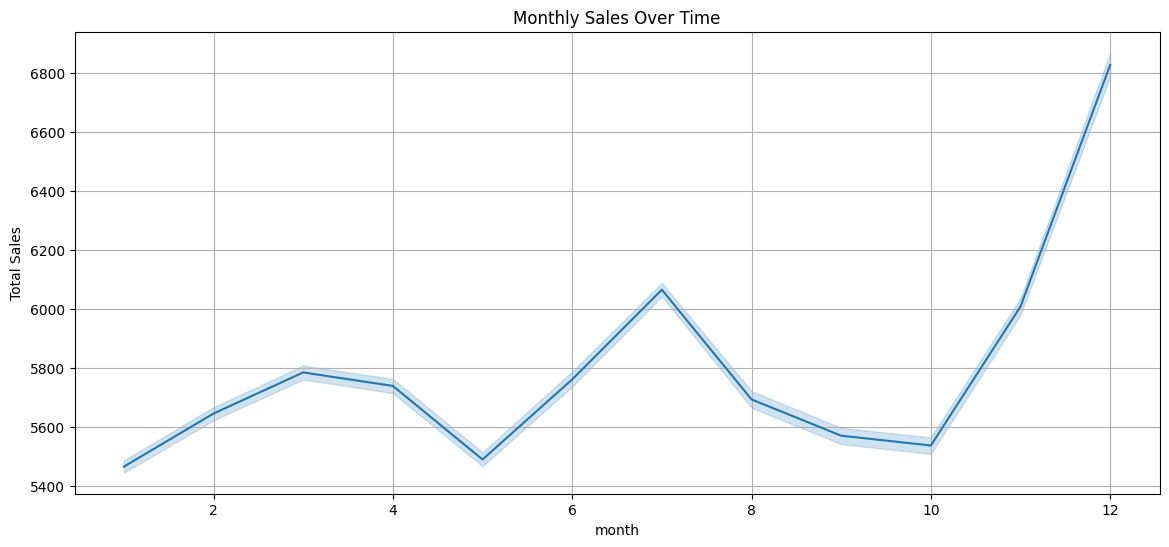

In [24]:


plt.figure(figsize=(14, 6))
sns.lineplot(data=train,x='month',y='Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

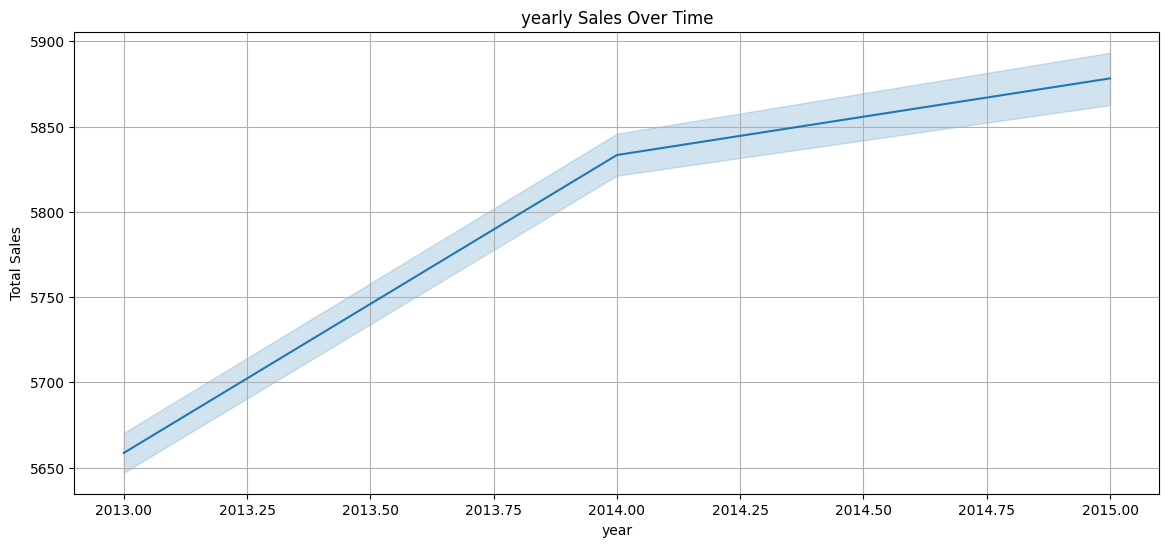

In [25]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=train,x='year',y='Sales')
plt.title('yearly Sales Over Time')
plt.xlabel('year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

<Figure size 1400x600 with 0 Axes>

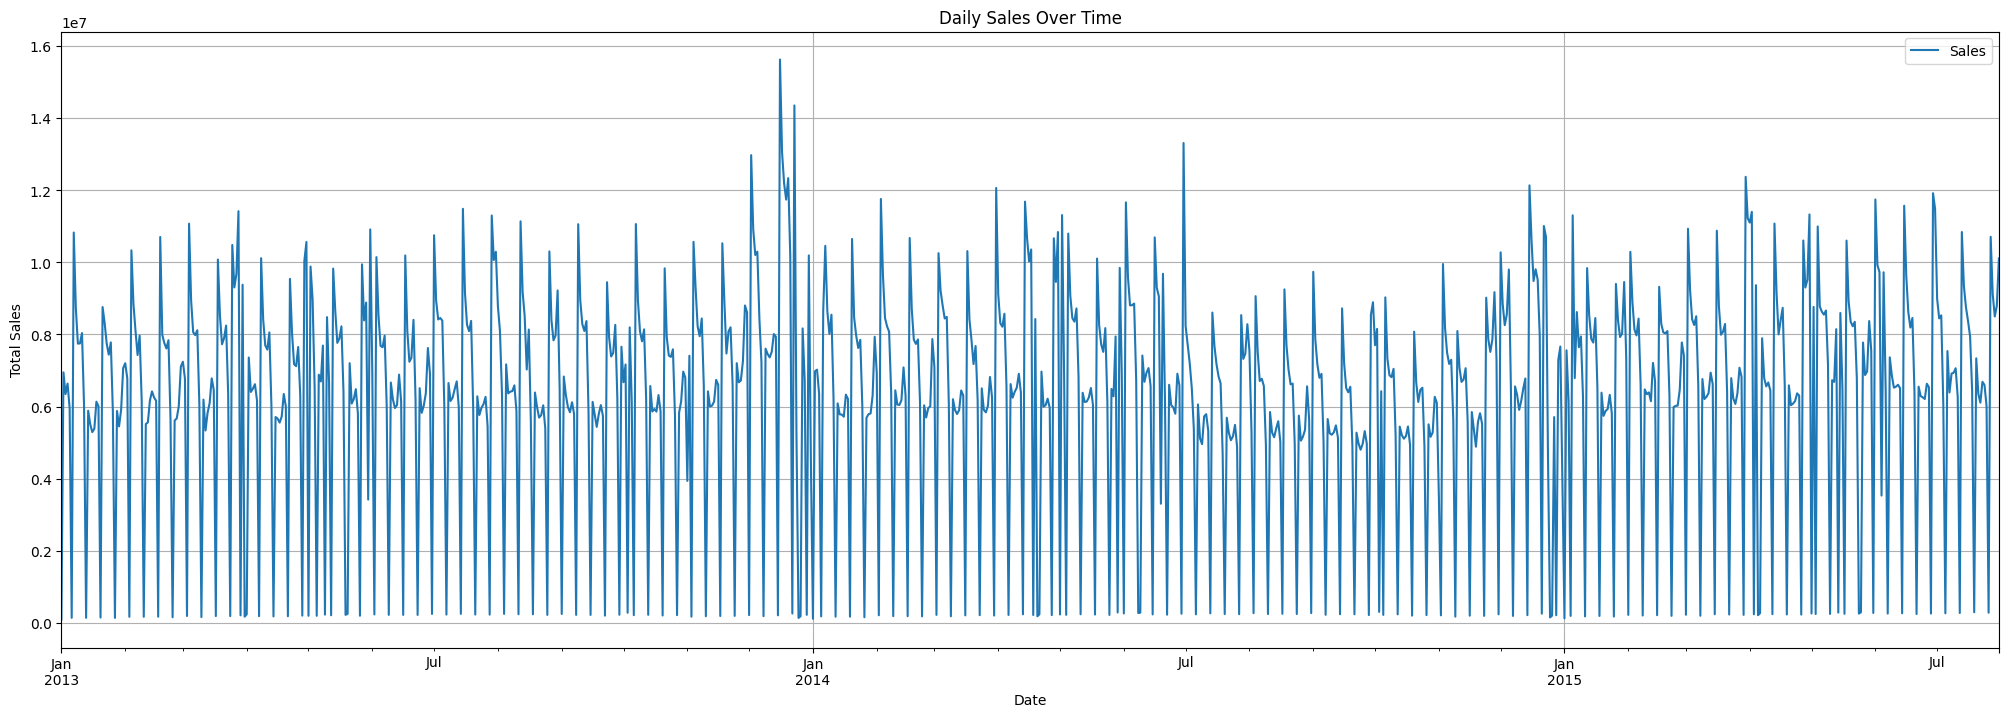

In [26]:
daily_sales = train.groupby('Date')['Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

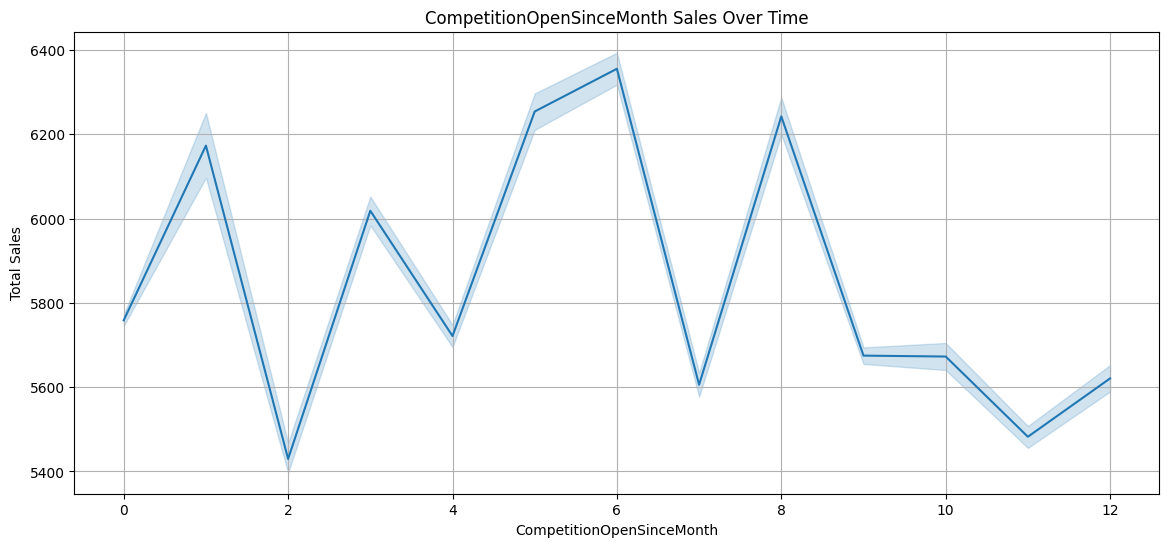

In [27]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=train,x='CompetitionOpenSinceMonth',y='Sales')
plt.title('CompetitionOpenSinceMonth Sales Over Time')
plt.xlabel('CompetitionOpenSinceMonth')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

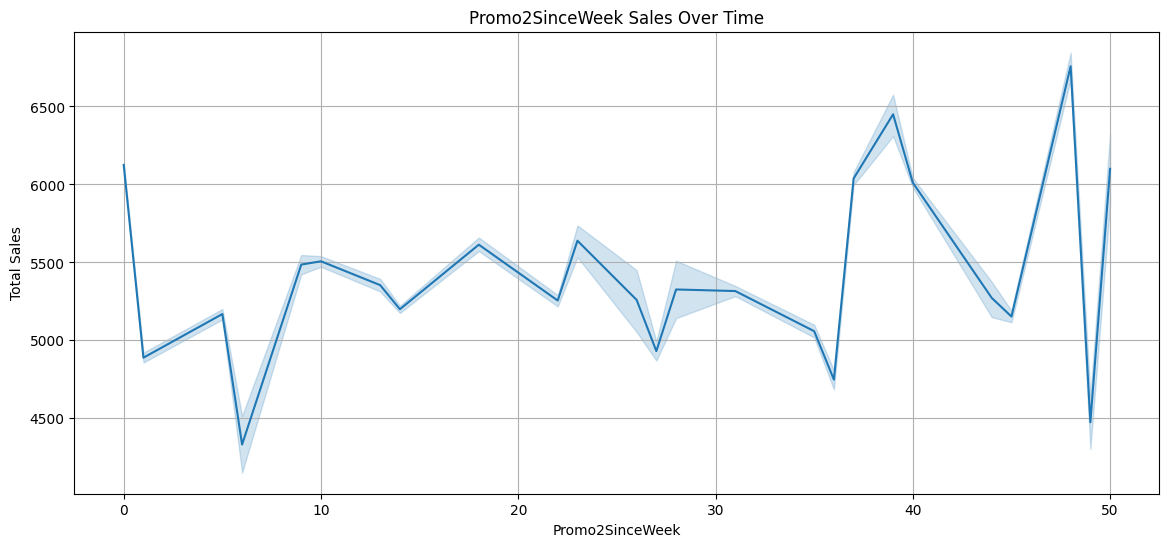

In [28]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=train,x='Promo2SinceWeek',y='Sales')
plt.title('Promo2SinceWeek Sales Over Time')
plt.xlabel('Promo2SinceWeek')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

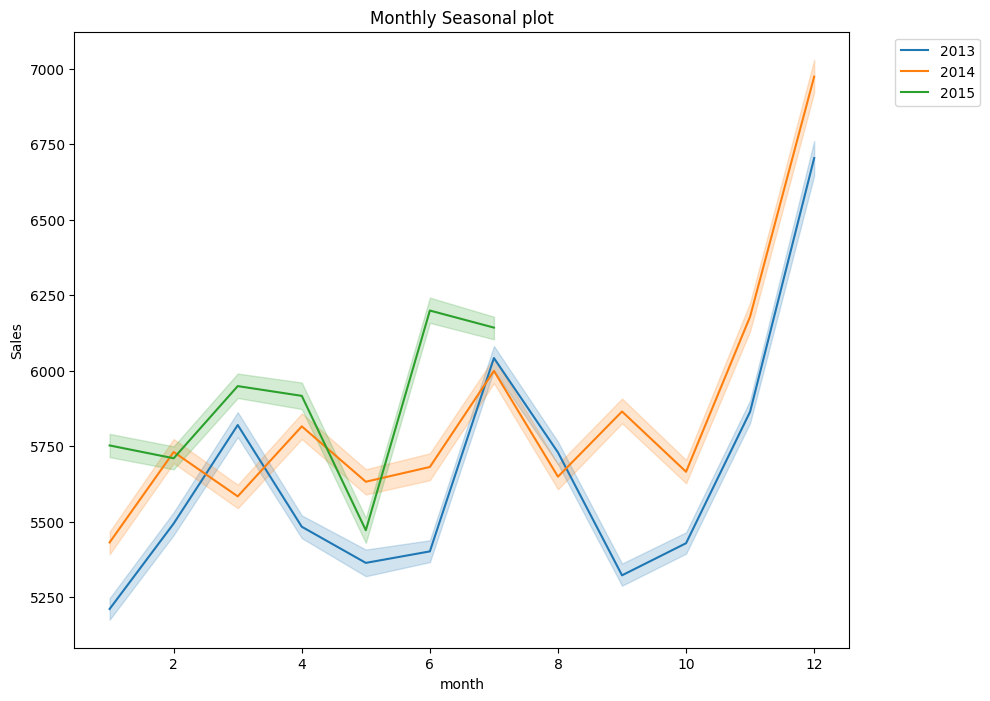

In [ ]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 legend='full',palette="tab10")

    plt.title(title+' Seasonal plot')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

monthly_quarter_line_plot(train,"month","Sales","year",title="Monthly")

# Time Series Analysis

## Store 1

In [30]:
store_df = train[(train['Store'] == 1) & (train['Open'] == 1)].copy()
store_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1115         1          4 2015-07-30   5020        546     1      1   
2230         1          3 2015-07-29   4782        523     1      1   
3345         1          2 2015-07-28   5011        560     1      1   
4460         1          1 2015-07-27   6102        612     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1009405      1          1 2013-01-07   7176        785     1      1   
1011635      1          6 2013-01-05   4997        635     1      0   
1012750      1          5 2013-01-04   4486        619     1      0   
1013865      1          4 2013-01-03   4327        578     1      0   
1014980      1          3 2013-01-02   5530        668     1      0   

        StateHoliday  SchoolHoliday StoreType  ... CompetitionOpenSinceMonth  \
0                  0              1         c  ...                       9.0   
1115               0              1         c  ...                       9.0   
2230               0              1         c  ...                       9.0   
3345               0              1         c  ...                       9.0   
4460               0              1         c  ...                       9.0   
...              ...            ...       ...  ...                       ...   
1009405            0              1         c  ...                       9.0   
1011635            0              1         c  ...                       9.0   
1012750            0              1         c  ...                       9.0   
1013865            0              1         c  ...                       9.0   
1014980            0              1         c  ...                       9.0   

         CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                          2008.0       0              0.0              0.0   
1115                       2008.0       0              0.0              0.0   
2230                       2008.0       0              0.0              0.0   
3345                       2008.0       0              0.0              0.0   
4460                       2008.0       0              0.0              0.0   
...                           ...     ...              ...              ...   
1009405                    2008.0       0              0.0              0.0   
1011635                    2008.0       0              0.0              0.0   
1012750                    2008.0       0              0.0              0.0   
1013865                    2008.0       0              0.0              0.0   
1014980                    2008.0       0              0.0              0.0   

         PromoInterval  day month  year  SalesPerCustomer  
0                    0   31     7  2015          9.482883  
1115                 0   30     7  2015          9.194139  
2230                 0   29     7  2015          9.143403  
3345                 0   28     7  2015          8.948214  
4460                 0   27     7  2015          9.970588  
...                ...  ...   ...   ...               ...  
1009405              0    7     1  2013          9.141401  
1011635              0    5     1  2013          7.869291  
1012750              0    4     1  2013          7.247173  
1013865              0    3     1  2013          7.486159  
1014980              0    2     1  2013          8.278443  

[781 rows x 22 columns]

In [31]:
store_df[store_df['Sales']==0]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval, day, month, year, SalesPerCustomer]
Index: []

[0 rows x 22 columns]

In [32]:
store_df.set_index('Date', inplace=True)
daily_sales = store_df['Sales'].resample('D').sum().fillna(0)

In [33]:
daily_sales

Date
2013-01-02    5530
2013-01-03    4327
2013-01-04    4486
2013-01-05    4997
2013-01-06       0
              ... 
2015-07-27    6102
2015-07-28    5011
2015-07-29    4782
2015-07-30    5020
2015-07-31    5263
Freq: D, Name: Sales, Length: 941, dtype: int64

### Decomposition

using additive model

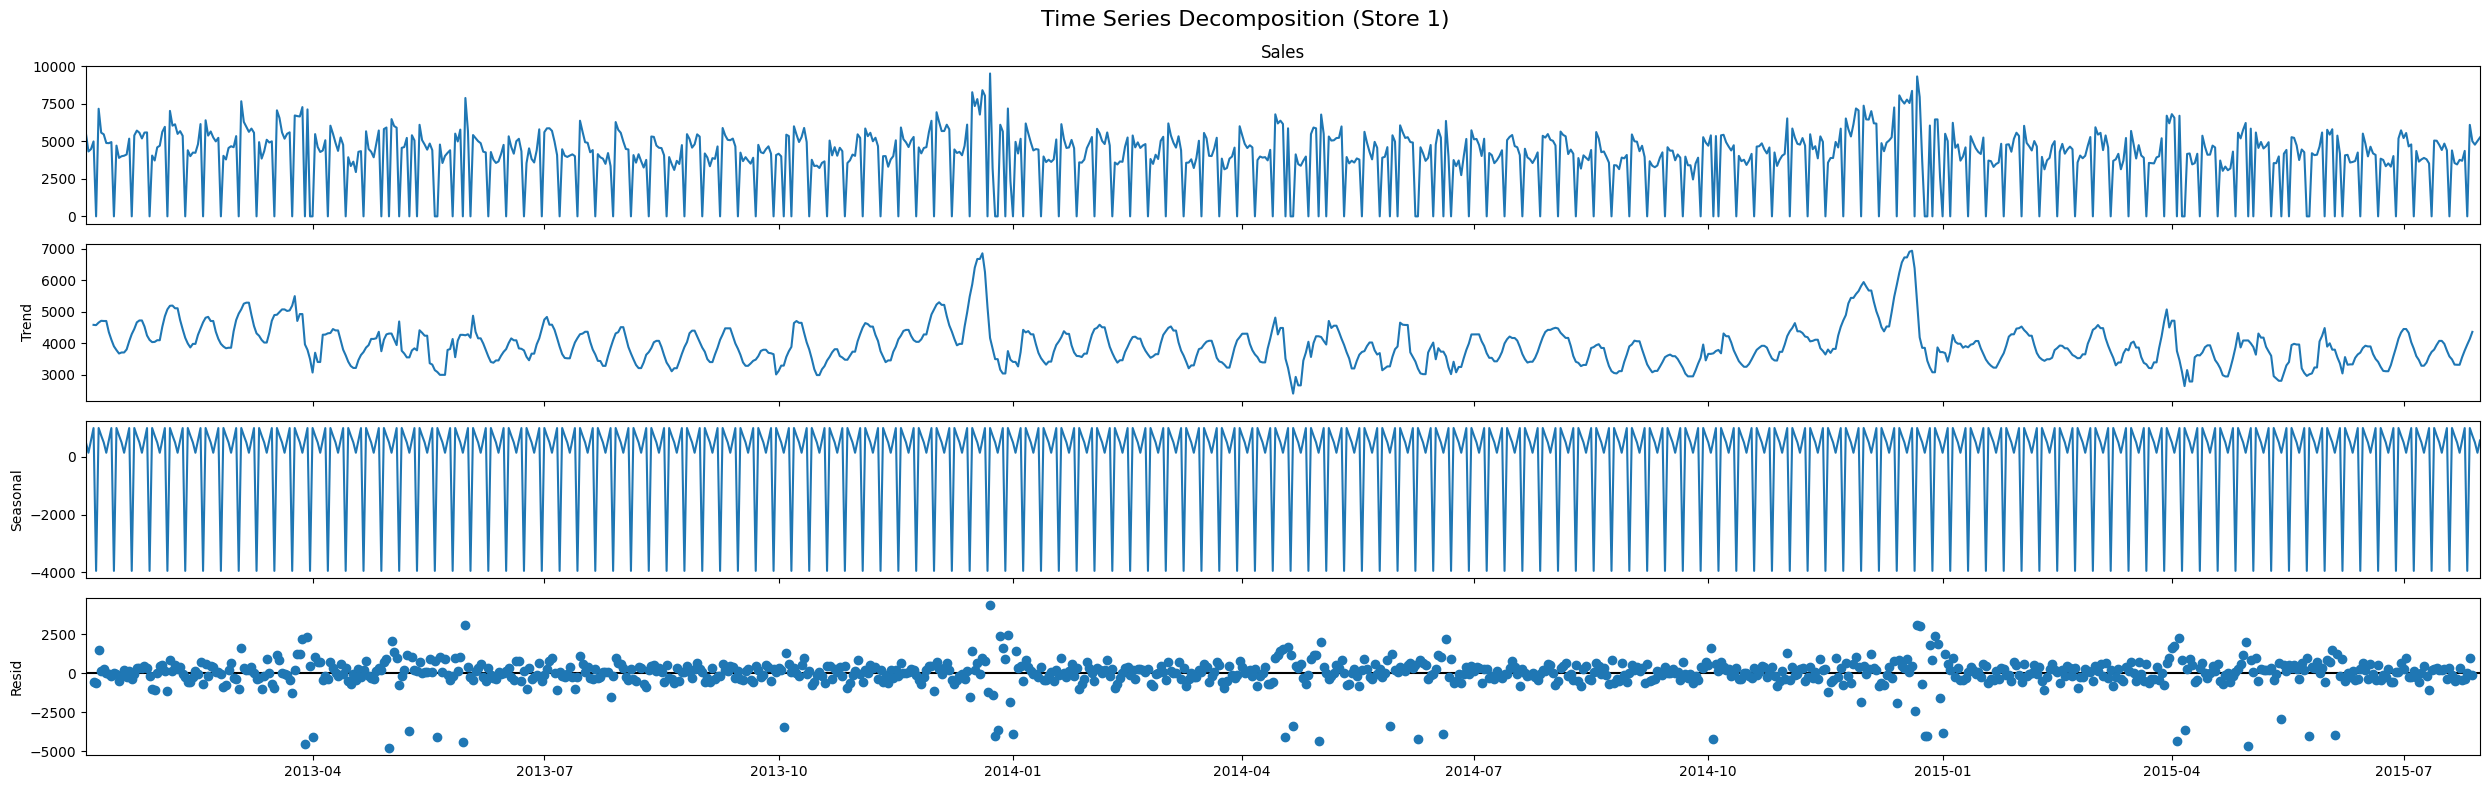

In [34]:
result = seasonal_decompose(daily_sales, model='additive', period=7)

result.plot()
plt.suptitle('Time Series Decomposition (Store 1)', fontsize=16)
plt.tight_layout()
plt.show()

Another Solution

The strength of the trend is: 0.18705288341494852 
 And the strength of Seasonality is: 0.7039296616044481


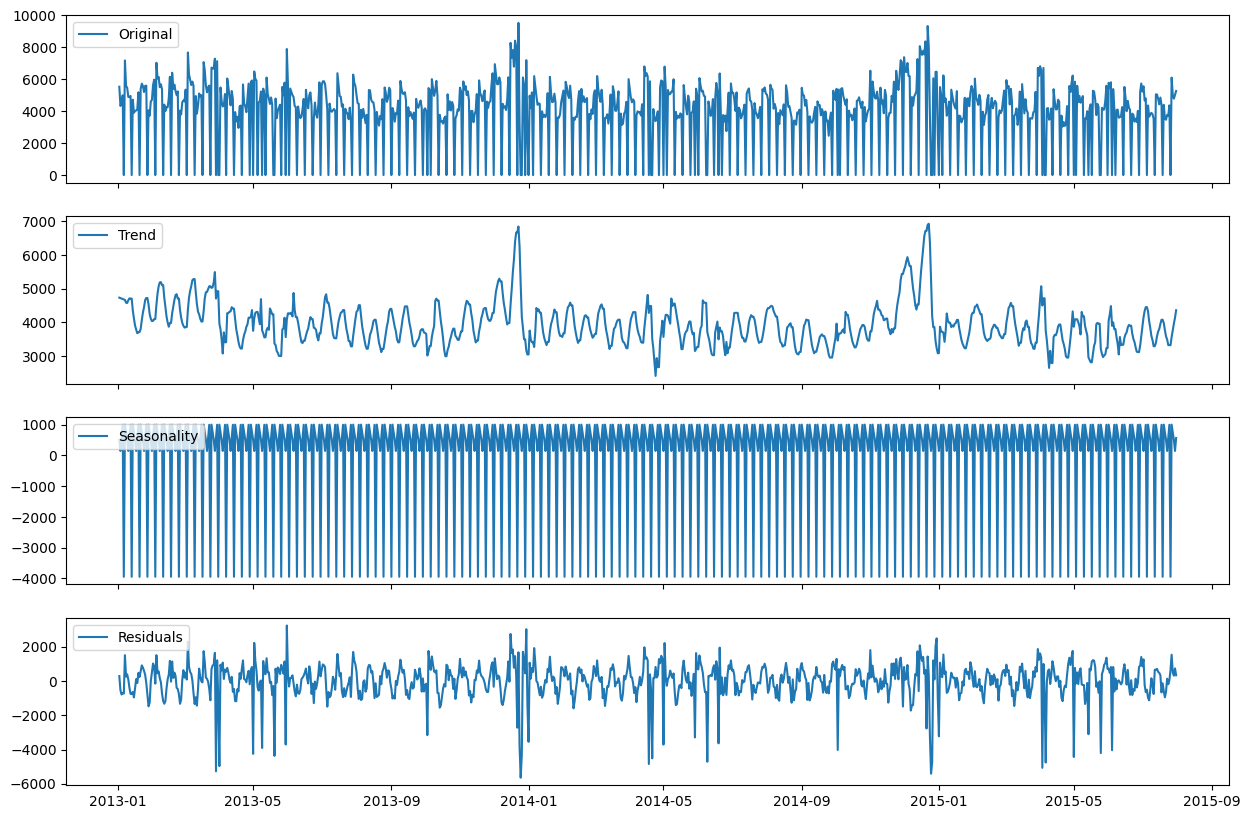

In [35]:
def classical_decomposition(data,period_value=7,model_type="additive",plots=True):

    result= seasonal_decompose(data,period=period_value, model=model_type,two_sided=False,
                                   extrapolate_trend='freq')
    
    trend = result.trend
    
    seasonal = result.seasonal
    residuals = result.resid
    
    if plots:
        resid_var = np.var(residuals.values)
        trend_resid_var = np.var(residuals.values+trend.values)
        seasonal_resid_var = np.var(residuals.values+seasonal.values)
        trend_strength = max(0,1-(resid_var/trend_resid_var))
        seasonal_strength = max(0,1-(resid_var/seasonal_resid_var))
        
        print(f"The strength of the trend is: {trend_strength} \n And the strength of Seasonality is: {seasonal_strength}")
        
        fig,axes = plt.subplots(4, 1, sharex=True, sharey=False)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        axes[0].plot(data, label='Original')
        axes[0].legend(loc='upper left')

        axes[1].plot(trend, label='Trend')
        axes[1].legend(loc='upper left')

        axes[2].plot(seasonal, label='Seasonality')
        axes[2].legend(loc='upper left')

        axes[3].plot(residuals, label='Residuals')
        axes[3].legend(loc='upper left')
    
    return trend,seasonal,residuals
trend_add, seasonal_add, resid_add = classical_decomposition(daily_sales,period_value=7,
                                                            model_type="additive",plots=True)

# Simple Model

## 1. Naive base

In [36]:
valid_data = daily_sales.iloc[-30:]
train_data =daily_sales.iloc[:-30]


In [37]:
print(train_data.shape)
print(valid_data.shape)

(911,)
(30,)


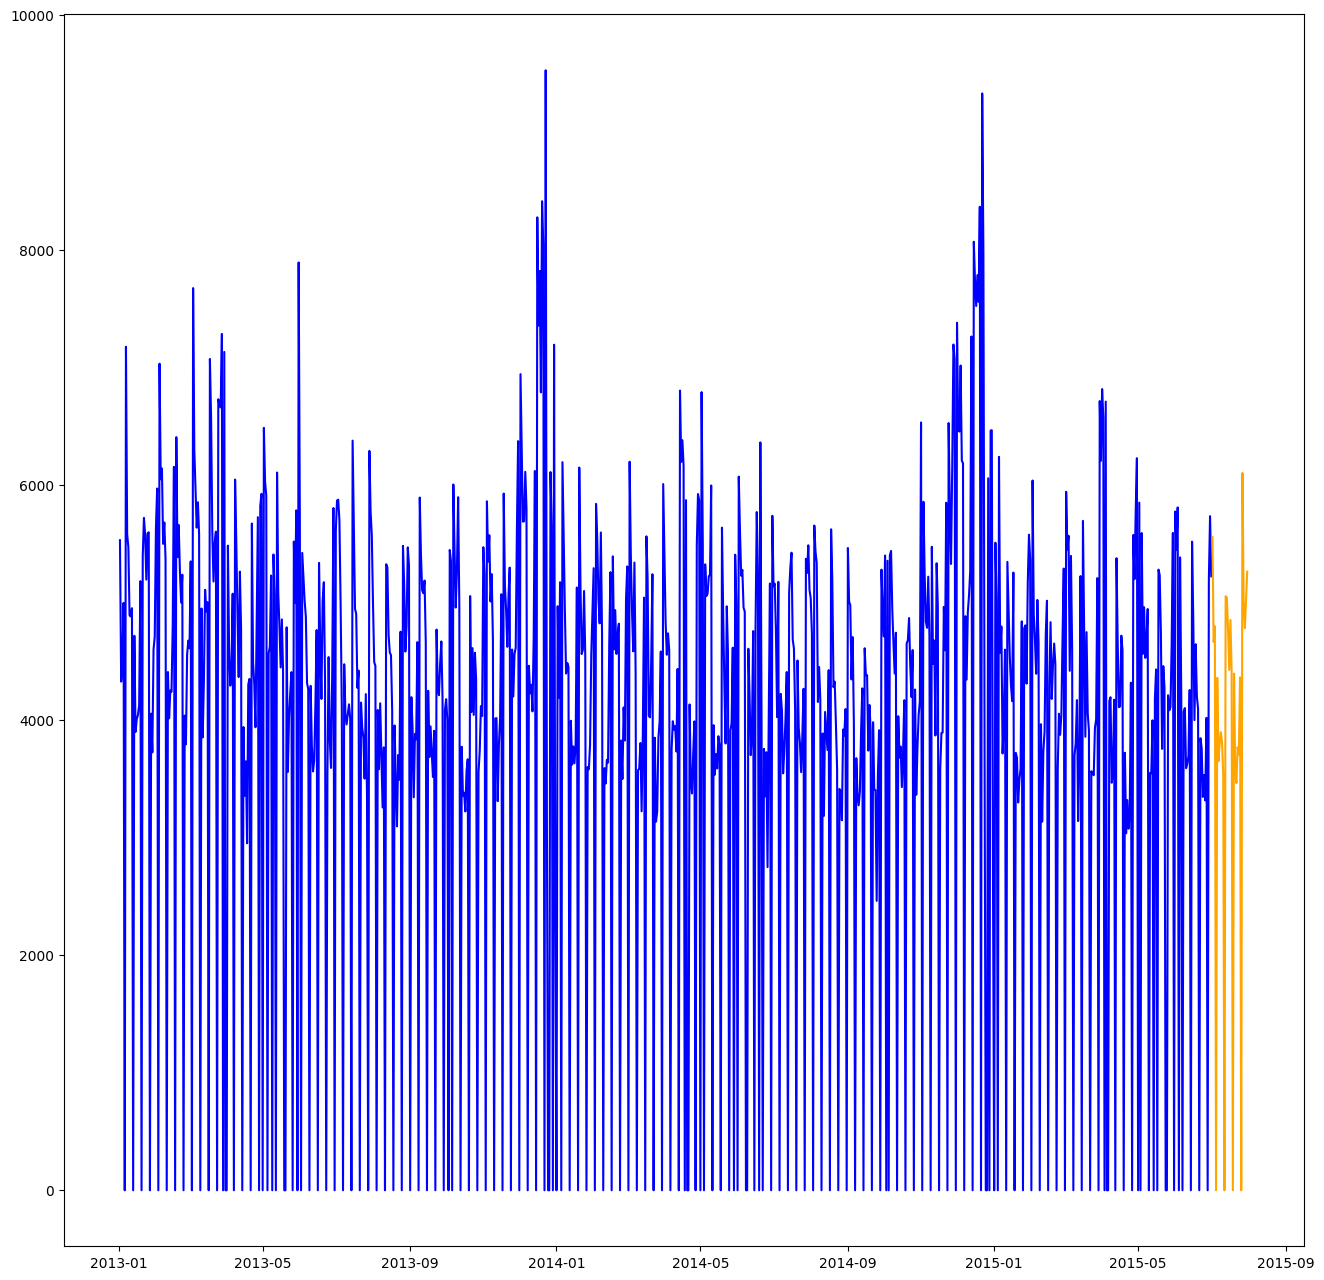

In [38]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(16)
fig.set_figwidth(16)

axes.plot(train_data, label='Train',color='blue')
axes.plot(valid_data, label='Test',color='orange')
plt.show()

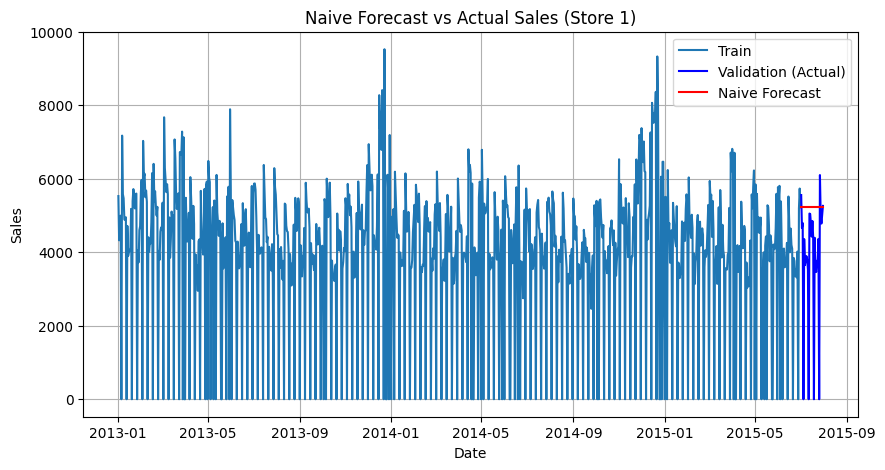

Naive Forecast Evaluation:
RMSE: 2129.73
MAE : 1438.50
MAPE: 21.36%


In [ ]:


naive_forecast = pd.Series(train_data.iloc[-1], index=valid_data.index)

plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(naive_forecast, label='Naive Forecast', color='red')
plt.legend()
plt.title('Naive Forecast vs Actual Sales (Store 1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

rmse = np.sqrt(mean_squared_error(valid_data, naive_forecast))
mae = mean_absolute_error(valid_data, naive_forecast)
mape = np.mean(np.abs((valid_data - naive_forecast) / valid_data.replace(0, np.nan))) * 100  # avoid divide by 0

print(f'Naive Forecast Evaluation:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

## Moving Average Method

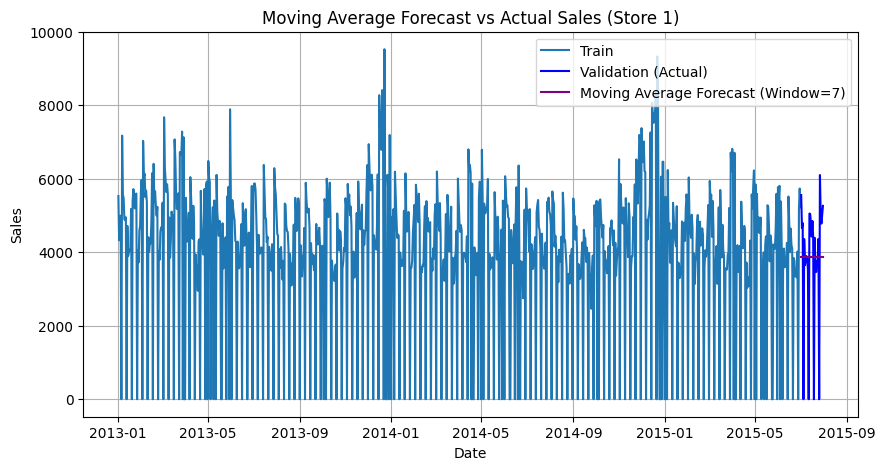

Moving Average Forecast Evaluation (Window=7):
RMSE: 1643.19
MAE : 1143.85
MAPE: 14.94%


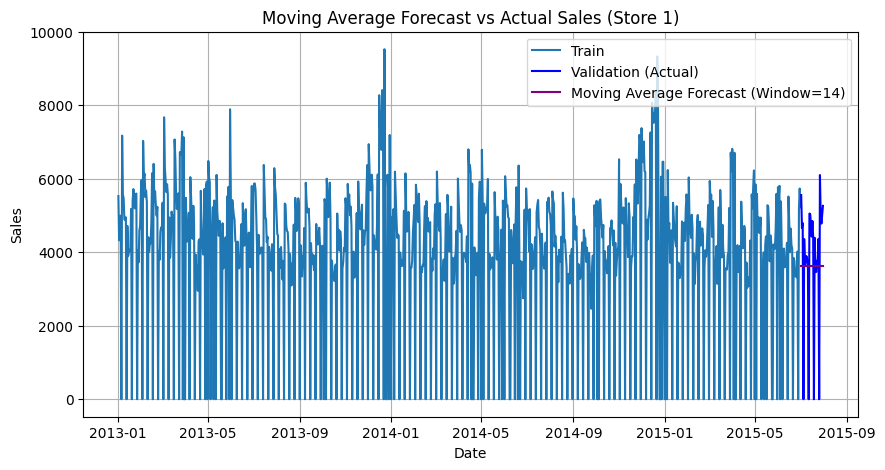

Moving Average Forecast Evaluation (Window=14):
RMSE: 1659.30
MAE : 1224.75
MAPE: 17.41%


In [ ]:
rolling_windows = [7,14]
for rolling_window in rolling_windows:
    moving_avg_value = train_data.rolling(window=rolling_window).mean().iloc[-1]

    moving_avg_forecast = pd.Series(moving_avg_value, index=valid_data.index)

   
    plt.figure(figsize=(10,5))
    plt.plot(train_data, label='Train')
    plt.plot(valid_data, label='Validation (Actual)', color='blue')
    plt.plot(moving_avg_forecast, label=f'Moving Average Forecast (Window={rolling_window})', color='purple')
    plt.legend()
    plt.title('Moving Average Forecast vs Actual Sales (Store 1)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()

  
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    rmse_ma = np.sqrt(mean_squared_error(valid_data, moving_avg_forecast))
    mae_ma = mean_absolute_error(valid_data, moving_avg_forecast)
    mape_ma = np.mean(np.abs((valid_data - moving_avg_forecast) / valid_data.replace(0, np.nan))) * 100

    print(f'Moving Average Forecast Evaluation (Window={rolling_window}):')
    print(f'RMSE: {rmse_ma:.2f}')
    print(f'MAE : {mae_ma:.2f}')
    print(f'MAPE: {mape_ma:.2f}%')


## Seasonal Naive method

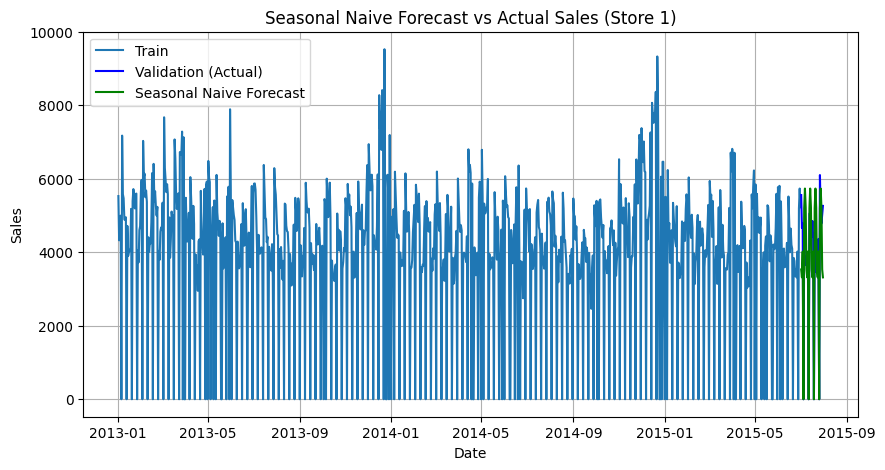

🌀 Seasonal Naive Forecast Evaluation:
RMSE: 1073.48
MAE : 838.77
MAPE: 22.24%


In [ ]:

season_length = 7
valid_length = len(valid_data)


last_season = train_data[-season_length:]


repeats = int(np.ceil(valid_length / season_length))
seasonal_naive_forecast = pd.Series(np.tile(last_season.values, repeats)[:valid_length], index=valid_data.index)


plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(seasonal_naive_forecast, label='Seasonal Naive Forecast', color='green')
plt.legend()
plt.title('Seasonal Naive Forecast vs Actual Sales (Store 1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


rmse_snaive = np.sqrt(mean_squared_error(valid_data, seasonal_naive_forecast))
mae_snaive = mean_absolute_error(valid_data, seasonal_naive_forecast)
mape_snaive = np.mean(np.abs((valid_data - seasonal_naive_forecast) / valid_data.replace(0, np.nan))) * 100

print(f'🌀 Seasonal Naive Forecast Evaluation:')
print(f'RMSE: {rmse_snaive:.2f}')
print(f'MAE : {mae_snaive:.2f}')
print(f'MAPE: {mape_snaive:.2f}%')


## Weighted Moving Average

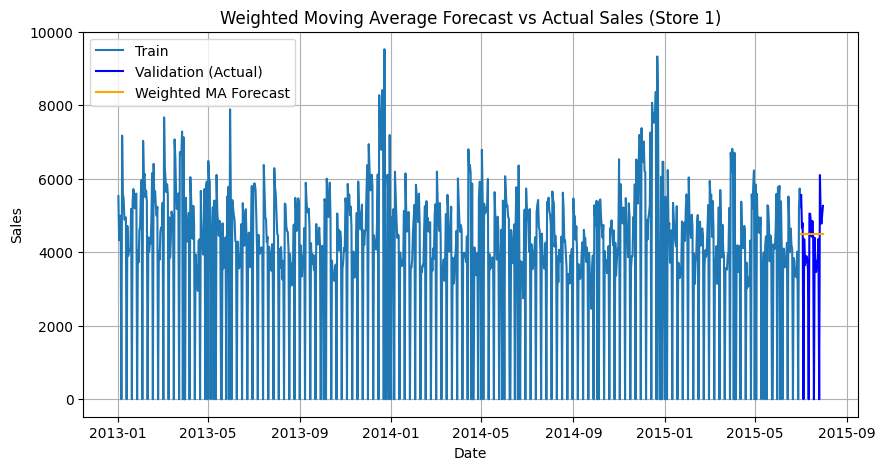

Weighted Moving Average Forecast Evaluation:
RMSE: 1759.66
MAE : 1092.31
MAPE: 13.19%


In [ ]:
import numpy as np

weights = np.array([0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.3])


def weighted_moving_average(series, weights):
    wma = []
    window = len(weights)
    for i in range(window - 1, len(series)):
        window_data = series[i - window + 1:i + 1]
        weighted_avg = np.dot(window_data, weights) / weights.sum()
        wma.append(weighted_avg)
    return pd.Series(wma, index=series.index[window - 1:])


wma_train = weighted_moving_average(train_data, weights)

wma_forecast_value = wma_train.iloc[-1]
wma_forecast = pd.Series(wma_forecast_value, index=valid_data.index)

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(wma_forecast, label='Weighted MA Forecast', color='orange')
plt.legend()
plt.title('Weighted Moving Average Forecast vs Actual Sales (Store 1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_wma = np.sqrt(mean_squared_error(valid_data, wma_forecast))
mae_wma = mean_absolute_error(valid_data, wma_forecast)
mape_wma = np.mean(np.abs((valid_data - wma_forecast) / valid_data.replace(0, np.nan))) * 100

print(f'Weighted Moving Average Forecast Evaluation:')
print(f'RMSE: {rmse_wma:.2f}')
print(f'MAE : {mae_wma:.2f}')
print(f'MAPE: {mape_wma:.2f}%')




### Another Solution

In [ ]:
def average_method(train_data,test_data):
 
    average_prediction = [np.mean(train_data)]*len(test_data)
    average_pred = pd.DataFrame(average_prediction)
    average_pred.index = test_data.index
    return average_pred

def naive_method(train_data,test_data):

    naiive_prediction = [train_data.iloc[-1]]*len(test_data)
    naiive_pred = pd.DataFrame(naiive_prediction)
    naiive_pred.index = test_data.index
    return naiive_pred

def seasonal_naive(train_data,test_data):

    dates = (test_data.index - np.timedelta64(52, 'W')).values.astype('datetime64[D]')
    dates_added = dates[2:] +np.timedelta64(1,'W')
    dates = np.concatenate((dates[:2],dates_added))

    seasonal_naive_prediction = train_data[train_data.index.isin(dates)].values # seasonal naive prediction
    
    seasonal_naive = pd.DataFrame(seasonal_naive_prediction).set_index(test_data.index)
    return seasonal_naive

def drift_method(train_data,test_data):
   
    y_t = train_data[len(train_data)-1]

    m = (y_t - train_data[1]) / len(train_data)

    h = np.linspace(0,len(test_data)-1, len(test_data))
 
    drift_prediction = y_t + m * h
    drift_pred = pd.DataFrame(drift_prediction).set_index(test_data.index)
    return drift_pred

In [44]:
average_pred = average_method(train_data,valid_data)
naiive_pred = naive_method(train_data,valid_data)
seasonal_naive_pred = seasonal_naive(train_data,valid_data)
drift_pred = drift_method(train_data,valid_data)

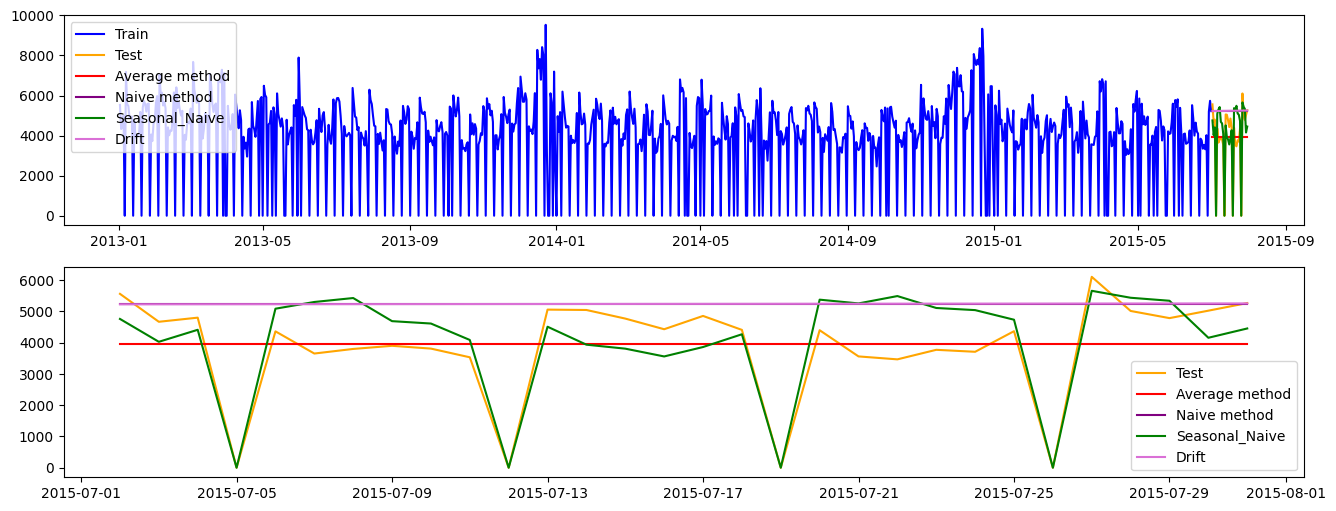

In [45]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data, label='Train',color='blue')
axes[0].plot(valid_data, label='Test',color='orange')

axes[0].plot(average_pred,label="Average method",color='red')
axes[0].plot(naiive_pred,label="Naive method",color='purple')
axes[0].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[0].plot(drift_pred,label='Drift',color='orchid')
axes[0].legend(loc='best')

axes[1].plot(valid_data, label='Test',color='orange')
axes[1].plot(average_pred,label="Average method",color='red')
axes[1].plot(naiive_pred,label="Naive method",color='purple')
axes[1].plot(seasonal_naive_pred, label='Seasonal_Naive',color='green')
axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100


def mdrae(y, y_hat, bnchmrk):
    abs_scaled_errors = np.abs(y - y_hat)/np.abs(y - bnchmrk+1e-10)
    return np.median(abs_scaled_errors)

def gmrae(y, y_hat, bnchmrk): 
    abs_scaled_errors = np.abs(y - y_hat)/np.abs(y - bnchmrk+1e-10)
    return np.exp(np.mean(np.log(abs_scaled_errors)))
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]
    
    percentage_error = np.abs((y_true_nz - y_pred_nz) / y_true_nz)
    return np.sqrt(np.mean(percentage_error ** 2))



def timeseries_evaluation_metrics(y_true, y_pred, y_bench):
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    MAE = mean_absolute_error(y_true, y_pred)
    MdRAE = mdrae(y_true, y_pred, y_bench)
    GMRAE = gmrae(y_true, y_pred, y_bench)
    RMSPE = rmspe(y_true, y_pred)
    return MAE,RMSE,MAPE,MdRAE,GMRAE, RMSPE

In [ ]:
MAE_average,RMSE_average,MAPE_average,MdRAE_average,GMRAE_average,RMSPE_average = timeseries_evaluation_metrics(valid_data,
                                                                                                average_pred[0],
                                                                                                naiive_pred[0])

MAE_naive,RMSE_naive,MAPE_naive,MdRAE_naive,GMRAE_naive,RMSPE_naive = timeseries_evaluation_metrics(valid_data,
                                                                                        naiive_pred[0],
                                                                                        naiive_pred[0])

MAE_snaive,RMSE_snaive,MAPE_snaive,MdRAE_snaive,GMRAE_snaive,RMSPE_snaive = timeseries_evaluation_metrics(valid_data,
                                                                                            seasonal_naive_pred[0],
                                                                                            naiive_pred[0])
MAE_drift,RMSE_drift,MAPE_drift,MdRAE_drift,GMRAE_drift ,RMSPE_drift= timeseries_evaluation_metrics(valid_data,
                                                                                        drift_pred[0],
                                                                                        naiive_pred[0])
rsme_wma, mae_wma ,mape_wma,mrdae_wma,gmrae_wma,rsmpe_wma=timeseries_evaluation_metrics(valid_data,
                                                                                     wma_forecast,
                                                                                     naiive_pred[0])

print(f"""
MAE for average method:{MAE_average}
RMSE for average method:{RMSE_average}
MAPE for average method:{MAPE_average}
MdRAE for average method:{MdRAE_average}
GMRAE for average method:{GMRAE_average}
RMSPE for average method:{RMSPE_average}""")

print(f"""
MAE for naive method:{MAE_naive}
RMSE for naive method:{RMSE_naive}
MAPE for naive method:{MAPE_naive}
MdRAE for naive method:{MdRAE_naive}
GMRAE for naive method:{GMRAE_naive}
RMSPE for naive method:{RMSPE_naive}""")


print(f"""
MAE for Seasonal naiive method:{MAE_snaive}
RMSE for Seasonal naiive method:{RMSE_snaive}
MAPE for Seasonal naiive method:{MAPE_snaive}
MdRAE for Seasonal naiive method:{MdRAE_snaive}
GMRAE for Seasonal naiive method:{GMRAE_snaive}
RMSPE for Seasonal naiive method:{RMSPE_snaive}""")

print(f"""
MAE for drift method:{MAE_drift}
RMSE for drift method:{RMSE_drift}
MAPE for drift method:{MAPE_drift}
MdRAE for drift method:{MdRAE_drift}
GMRAE for drift method:{GMRAE_drift}
RMSPE for drift method:{RMSPE_drift}""")

print(f"""
MAE for weighted moving average method:{mae_wma}
RMSE for weighted moving average method:{rsme_wma}
MAPE for weighted moving average method:{mape_wma}          
MdRAE for weighted moving average method:{mrdae_wma}
GMRAE for weighted moving average method:{gmrae_wma}
RMSPE for weighted moving average method:{rsmpe_wma}""")



MAE for average method:1129.1544456641054
RMSE for average method:1645.3432459085884
MAPE for average method:40.35725315892857
MdRAE for average method:0.7567665436567653
GMRAE for average method:0.8259526345898468
RMSPE for average method:0.1658026911160189

MAE for naive method:1438.5
RMSE for naive method:2129.734623530985
MAPE for naive method:42.6691120543977
MdRAE for naive method:1.000000000000073
GMRAE for naive method:1.000000000000053
RMSPE for naive method:0.2674721872145277

MAE for Seasonal naiive method:780.8333333333334
RMSE for Seasonal naiive method:941.3741551582984
MAPE for Seasonal naiive method:19.966292670400964
MdRAE for Seasonal naiive method:1.0325485052758419
GMRAE for Seasonal naiive method:0.0
RMSPE for Seasonal naiive method:0.25661104523254397

MAE for drift method:1449.2205268935234
RMSE for drift method:2138.160889285807
MAPE for drift method:42.83751887407929
MdRAE for drift method:1.008371751359165
GMRAE for drift method:0.9799620612305039
RMSPE for d

# ETS Model

### Simple Exponential Smoothing

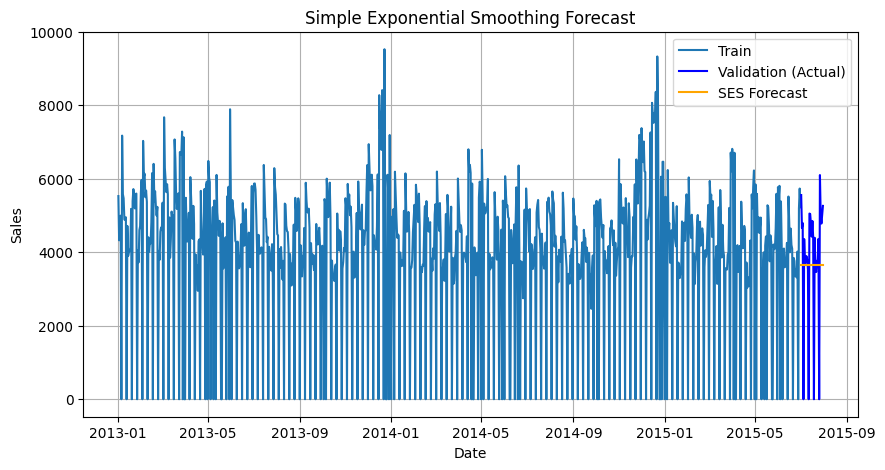

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


ses_model = SimpleExpSmoothing(train_data).fit()
ses_forecast = ses_model.forecast(len(valid_data))


plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(ses_forecast, label='SES Forecast', color='orange')
plt.legend()
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

mae_ses, rmse_ses, mape_ses, mdrae_ses, gmrae_ses, rmspe_ses = timeseries_evaluation_metrics(
    valid_data.values, ses_forecast.values, naiive_pred[0].values)


In [ ]:

print(f'Simple Exponential Smoothing Evaluation:')
print(f'RMSE: {rmse_ses:.2f}')
print(f'MAE : {mae_ses:.2f}')
print(f'MAPE: {mape_ses:.2f}%')
print(f'MdRAE: {mdrae_ses:.2f}')
print(f'GMRAE: {gmrae_ses:.2f}')
print(f'RMSPE: {rmspe_ses:.2f}')


Simple Exponential Smoothing Evaluation:
RMSE: 1657.64
MAE : 1218.21
MAPE: 43.71%
MdRAE: 0.87
GMRAE: 0.70
RMSPE: 0.21


###  Holt’s Linear Trend Method

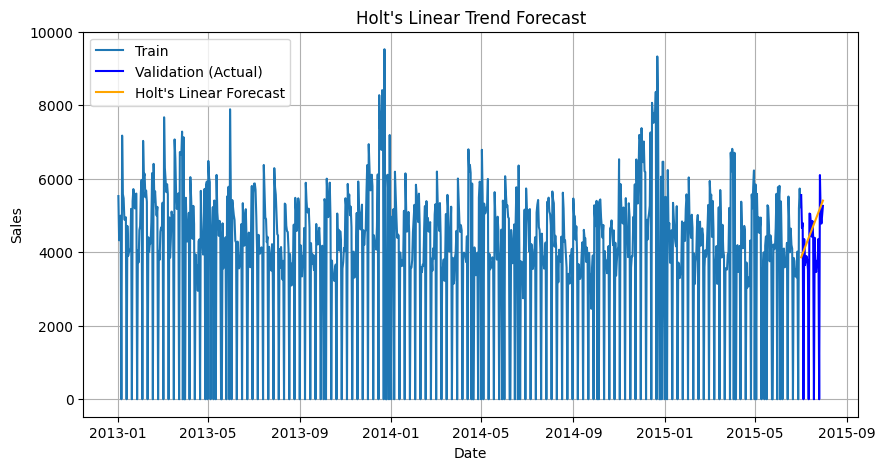

In [ ]:
from statsmodels.tsa.holtwinters import Holt


holt_model = Holt(train_data).fit()
holt_forecast = holt_model.forecast(len(valid_data))


plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(holt_forecast, label="Holt's Linear Forecast", color='orange')
plt.legend()
plt.title("Holt's Linear Trend Forecast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


mae_holt, rmse_holt, mape_holt, mdrae_holt, gmrae_holt, rmspe_holt = timeseries_evaluation_metrics(
    valid_data.values, holt_forecast.values, naiive_pred[0].values)


In [133]:
print(f"Holt's Linear Trend Forecast Evaluation:")
print(f'RMSE: {rmse_holt:.2f}')
print(f'MAE : {mae_holt:.2f}')
print(f'MAPE: {mape_holt:.2f}%')
print(f'MdRAE: {mdrae_holt:.2f}')
print(f'GMRAE: {gmrae_holt:.2f}')
print(f'RMSPE: {rmspe_holt:.2f}')

Holt's Linear Trend Forecast Evaluation:
RMSE: 1827.73
MAE : 1167.59
MAPE: 39.14%
MdRAE: 0.84
GMRAE: 0.83
RMSPE: 0.19


### Holt-Winters (Seasonal Exponential Smoothing)

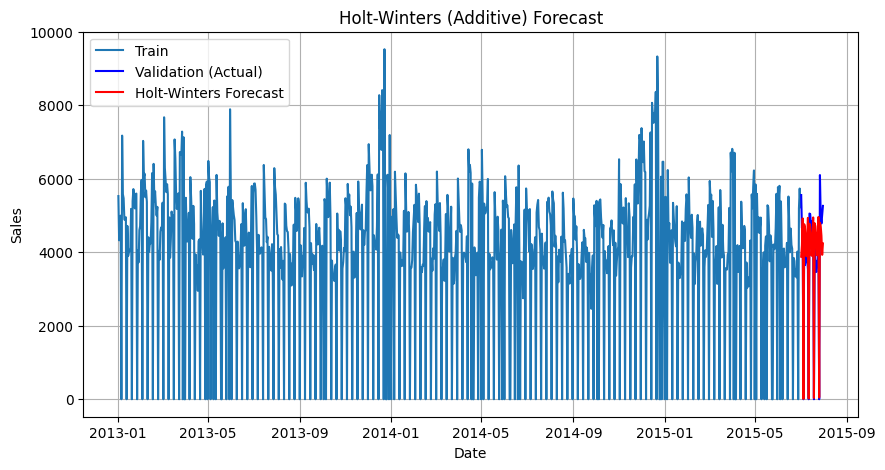

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


hw_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=7).fit()
hw_forecast = hw_model.forecast(len(valid_data))


plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train')
plt.plot(valid_data, label='Validation (Actual)', color='blue')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='red')
plt.legend()
plt.title('Holt-Winters (Additive) Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


mae_hw, rmse_hw, mape_hw, mdrae_hw, gmrae_hw, rmspe_hw = timeseries_evaluation_metrics(
    valid_data.values, hw_forecast.values, naiive_pred[0].values)


In [135]:
print(f"Holt's Linear Trend Forecast Evaluation:")
print(f'RMSE: {rmse_holt:.2f}')
print(f'MAE : {mae_holt:.2f}')
print(f'MAPE: {mape_holt:.2f}%')
print(f'MdRAE: {mdrae_holt:.2f}')
print(f'GMRAE: {gmrae_holt:.2f}')
print(f'RMSPE: {rmspe_holt:.2f}')

Holt's Linear Trend Forecast Evaluation:
RMSE: 1827.73
MAE : 1167.59
MAPE: 39.14%
MdRAE: 0.84
GMRAE: 0.83
RMSPE: 0.19


In [ ]:

results_df = pd.DataFrame({
    'Model': ['Simple Exp Smoothing', 'Holt Linear', 'Holt-Winters'],
    'RMSE': [rmse_ses, rmse_holt, rmse_hw],
    'MAE': [mae_ses, mae_holt, mae_hw],
    'MAPE': [mape_ses, mape_holt, mape_hw],
    'MdRAE': [mdrae_ses, mdrae_holt, mdrae_hw],
    'GMRAE': [gmrae_ses, gmrae_holt, gmrae_hw],
    'RMSPE': [rmspe_ses, rmspe_holt, rmspe_hw]
})

print("\n Model Performance Comparison:")
results_df.head()




 Model Performance Comparison:


Model         RMSE          MAE       MAPE     MdRAE  \
0  Simple Exp Smoothing  1657.643281  1218.208604  43.712231  0.866017   
1           Holt Linear  1827.727870  1167.587888  39.137010  0.837639   
2          Holt-Winters   713.932748   557.849990  39.094611  0.660679   

      GMRAE     RMSPE  
0  0.695249  0.206423  
1  0.825393  0.187933  
2  0.365925  0.177227

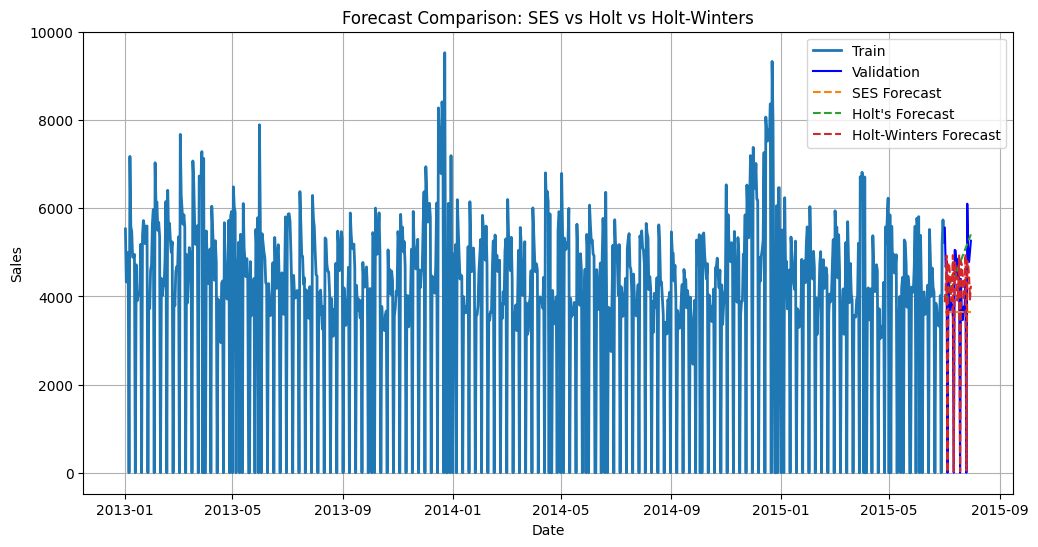

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(train_data, label='Train', linewidth=2)
plt.plot(valid_data, label='Validation', color='blue')
plt.plot(ses_forecast, label='SES Forecast', linestyle='--')
plt.plot(holt_forecast, label="Holt's Forecast", linestyle='--')
plt.plot(hw_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.title('Forecast Comparison: SES vs Holt vs Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


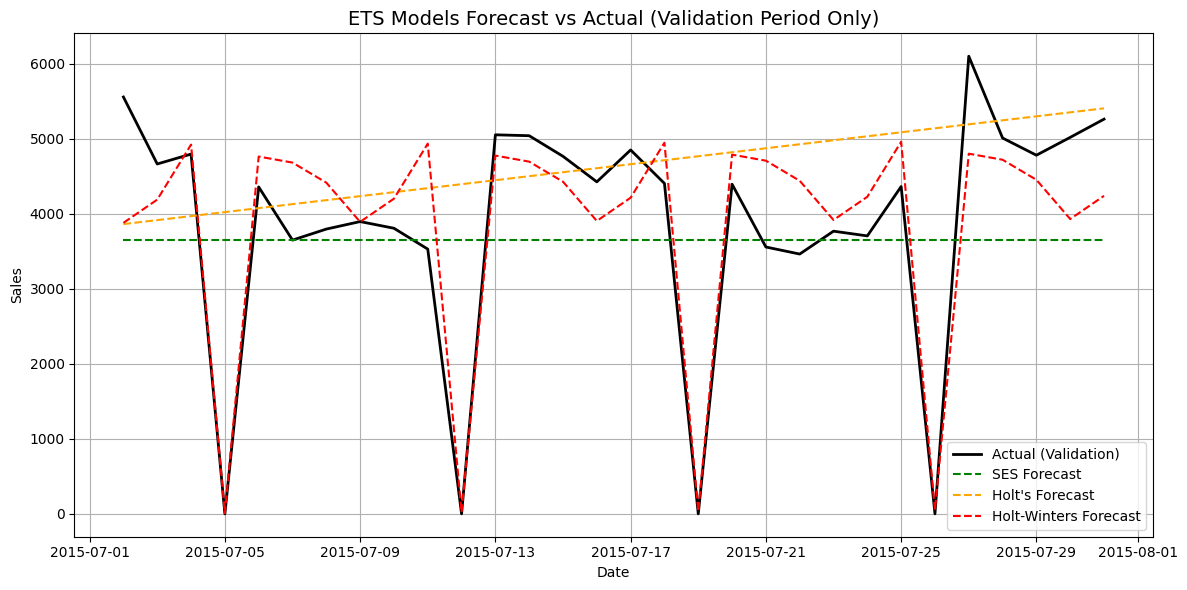

In [ ]:
plt.figure(figsize=(12, 6))


plt.plot(valid_data.index, valid_data.values, label='Actual (Validation)', color='black', linewidth=2)


plt.plot(valid_data.index, ses_forecast, label='SES Forecast', linestyle='--', color='green')
plt.plot(valid_data.index, holt_forecast, label="Holt's Forecast", linestyle='--', color='orange')
plt.plot(valid_data.index, hw_forecast, label='Holt-Winters Forecast', linestyle='--', color='red')


plt.title('ETS Models Forecast vs Actual (Validation Period Only)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ARIMA Models

### Define kpss_test function

In [ ]:
def kpss_test(data,threshold=0.05,regression="c"):
    result = kpss(data,regression="c")

    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {}'.format(key, value))
    if result[1]<=threshold:
        print("The data is not stationary")
    else:
        print("The data is stationary")

### Define adf_test function

In [ ]:
def adf_test(data,threshold=0.05):
   
    result = adfuller(data,autolag="AIC")

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    if result[1] <= threshold:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

### Define autocorrelatin_graphs function

In [141]:
def autocorrelatin_graphs(value,n_lags,title_text):
    fig, axes = plt.subplots(3,1,dpi=80)
    fig.set_figheight(12)
    fig.set_figwidth(16)
    value_plot = axes[0].plot(value)
    plt.title(f'{title_text}')
    acf_plot = plot_acf(value, lags=n_lags, title=f'Autocorrelation in {title_text}',ax=axes[1])
    plt.xlabel('Lags')
    pacf_plot = plot_pacf(value, lags=n_lags, title=f'Partial Autocorrelation in {title_text}',ax=axes[2])
    plt.xlabel('Lags')
    plt.tight_layout()
    plt.show()

### Plot Rolling mean and STD

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

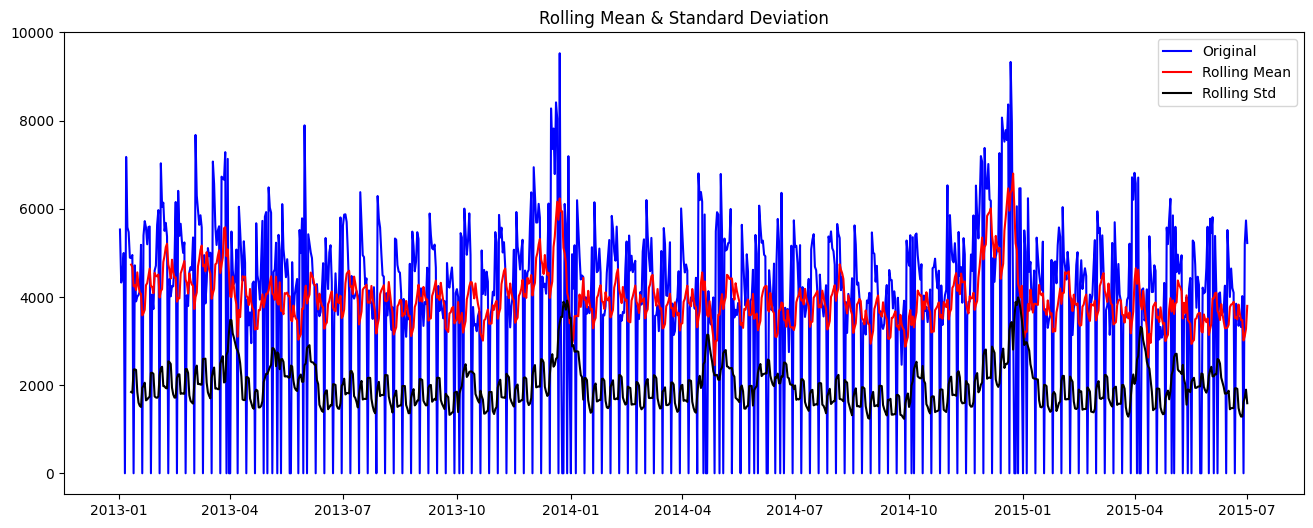

In [ ]:
fig ,axes =plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(16)


rolmean = train_data.rolling( window=10).mean()
rolstd = train_data.rolling(window=10).std()

orig = axes.plot(train_data, color='blue',label='Original')
mean = axes.plot(rolmean, color='red', label='Rolling Mean')
std = axes.plot(rolstd, color='black', label = 'Rolling Std')
axes.legend(loc='best')
axes.set_title('Rolling Mean & Standard Deviation')

### Check stationarity

In [143]:
adf_test(train_data)

ADF Statistic: -4.260195580975474
p-value: 0.0005202517126751235
Critical Values:
	1%: -3.4377271455534597
	5%: -2.864796595407904
	10%: -2.5685040379415454
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [144]:
kpss_test(train_data)

KPSS Statistic: 0.34549224038501924
p-value: 0.1
Lags Used: 1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The data is stationary


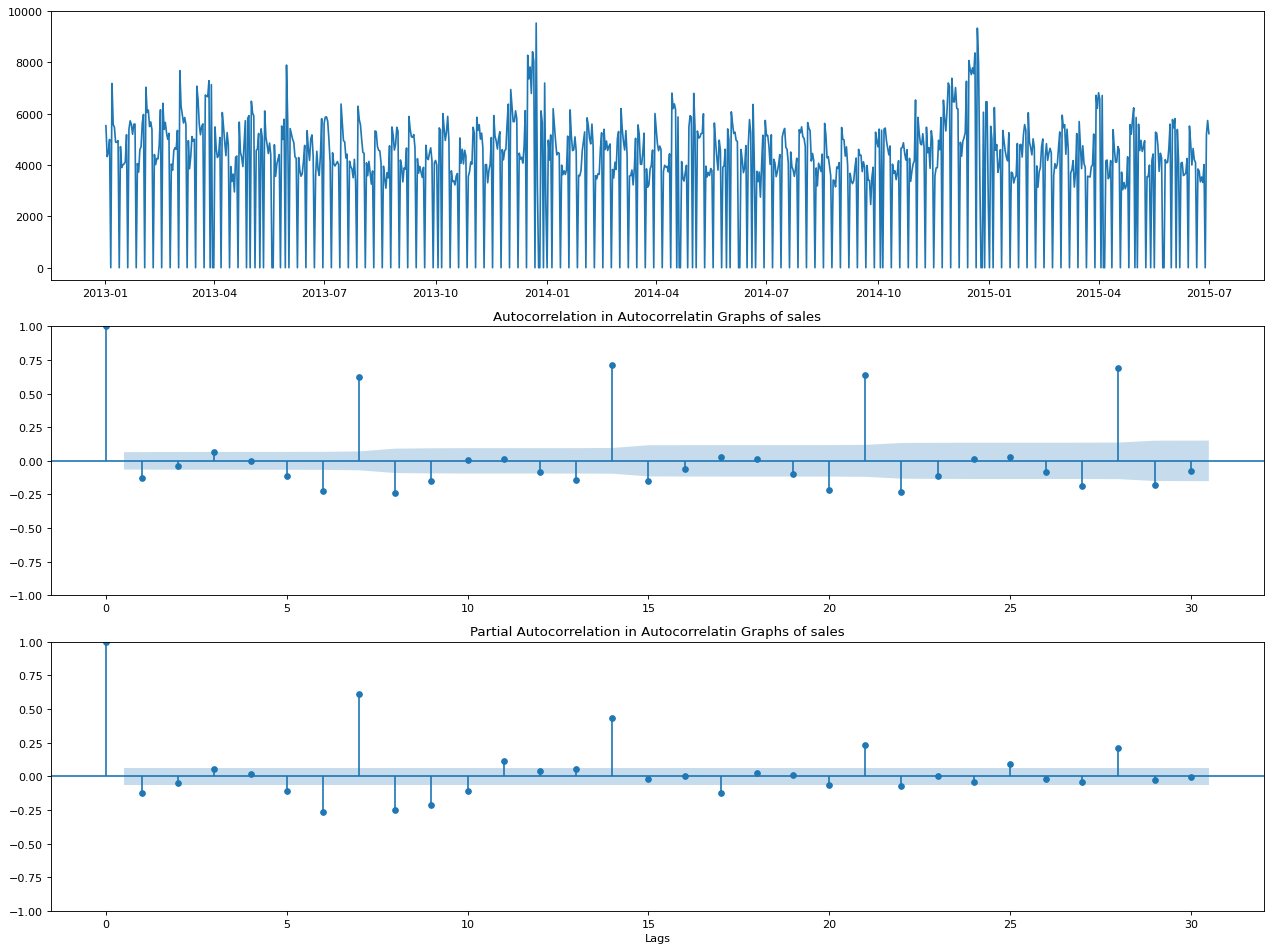

In [145]:
autocorrelatin_graphs(train_data, n_lags=30, title_text="Autocorrelatin Graphs of sales")

### Fitting ARIMA Model

In [146]:
ARIMA_model = ARIMA(train_data, order=(1, 0, 1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  911
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8219.158
Date:                Thu, 29 May 2025   AIC                          16446.317
Time:                        12:25:19   BIC                          16465.575
Sample:                    01-02-2013   HQIC                         16453.669
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3952.5916     80.299     49.223      0.000    3795.208    4109.976
ar.L1          0.0867      0.246      0.352      0.725      -0.395       0.569
ma.L1         -0.2193      0.242     -0.907      0.365      -0.693       0.255
sigma2      4.034e+06   2.29e+05     17.602      0.000    3.58e+06    4.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                84.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.75
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start_index = valid_data.index.min()
end_index = valid_data.index.max()


arima_preds = ARIMA_model_fit.predict(start=start_index, end=end_index)

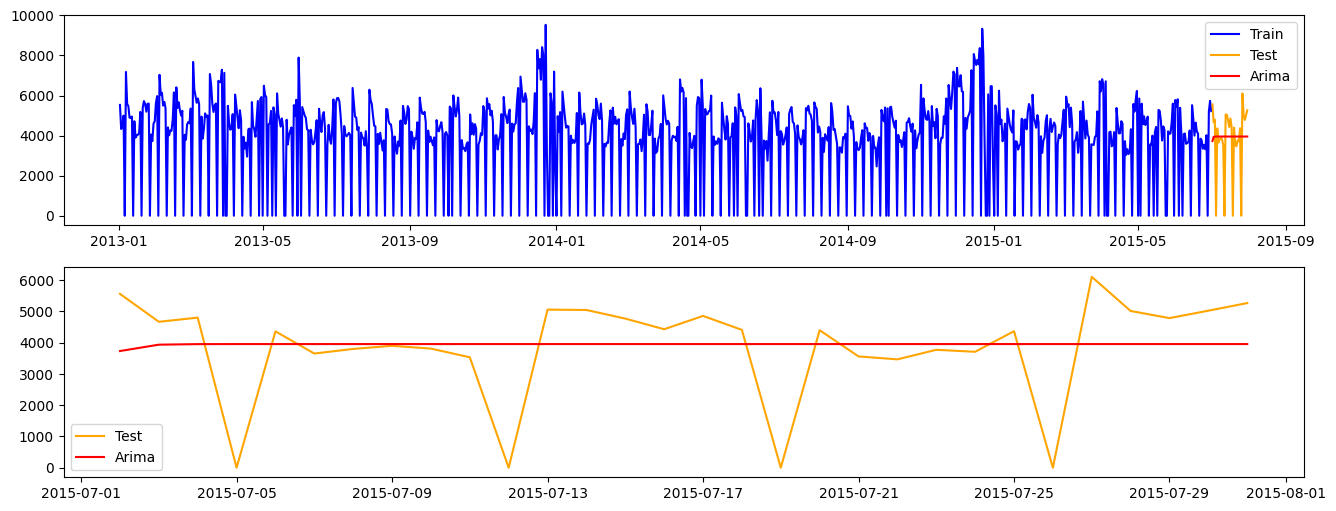

In [148]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data, label='Train',color='blue')
axes[0].plot(valid_data, label='Test',color='orange')

axes[0].plot(arima_preds,label="Arima",color='red')
axes[0].legend(loc='best')

axes[1].plot(valid_data, label='Test',color='orange')
axes[1].plot(arima_preds,label="Arima",color='red')
axes[1].legend(loc='best')
plt.show()

In [149]:
MAE_arima, RMSE_arima, MAPE_arima, MdRAE_arima, GMRAE_arima, RMSPE_arima = timeseries_evaluation_metrics(
    valid_data.values, arima_preds.values, naiive_pred[0].values)

In [150]:
print(f'Arima Model Evaluation:')
print(f'RMSE: {RMSE_arima:.2f}')
print(f'MAE : {MAE_arima:.2f}')
print(f'MAPE: {MAPE_arima:.2f}%')
print(f'MdRAE: {MdRAE_arima:.2f}')
print(f'GMRAE: {GMRAE_arima:.2f}')
print(f'RMSPE: {RMSPE_arima:.2f}')

Arima Model Evaluation:
RMSE: 1653.36
MAE : 1137.27
MAPE: 40.56%
MdRAE: 0.76
GMRAE: 0.83
RMSPE: 0.17


### SARIMAX

In [ ]:

SARIMAX_model = SARIMAX(train_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
SARIMAX_model_fit = SARIMAX_model.fit()

In [152]:
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  911
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -7850.329
Date:                           Thu, 29 May 2025   AIC                          15710.658
Time:                                   12:27:24   BIC                          15734.731
Sample:                               01-02-2013   HQIC                         15719.849
                                    - 07-01-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8200      0.069     11.951      0.000       0.686       0.955
ma.L1         -0.6763      0.087     -7.744      0.000      -0.847      -0.505
ar.S.L7        1.0000   1.61e-05   6.19e+04      0.000       1.000       1.000
ma.S.L7       -0.9989      0.049    -20.406      0.000      -1.095      -0.903
sigma2      2.981e+06   1.61e-08   1.85e+14      0.000    2.98e+06    2.98e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):              2111.14
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -1.61
Prob(H) (two-sided):                  0.08   Kurtosis:                         9.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+29. Standard errors may be unstable.
"""

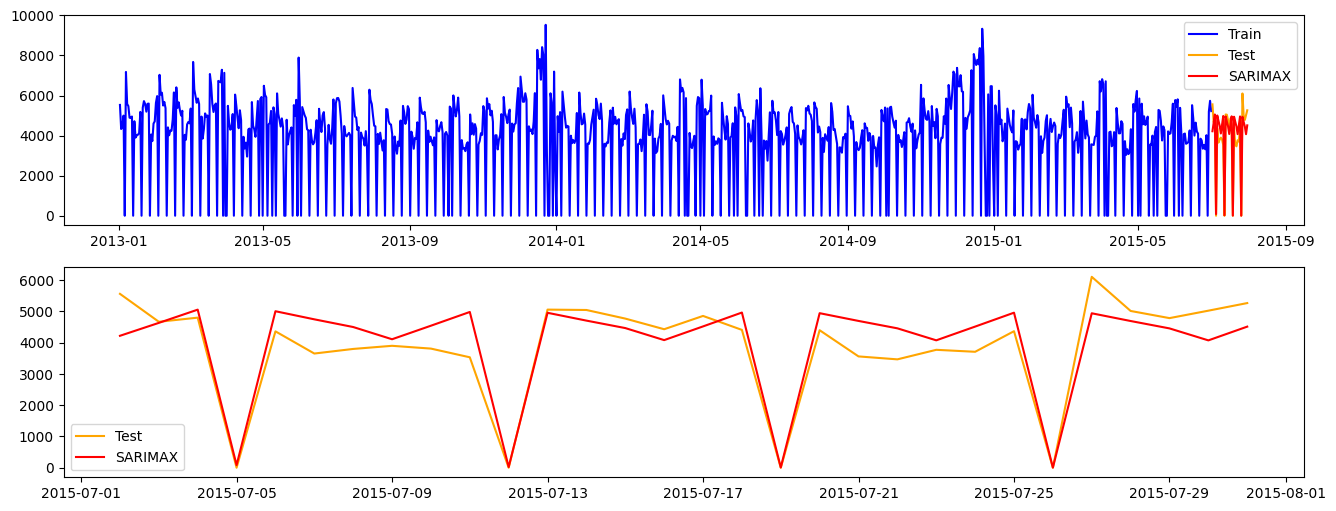

In [ ]:
start_index = valid_data.index.min()
end_index = valid_data.index.max()


SARIMAX_preds = SARIMAX_model_fit.predict(start=start_index, end=end_index)
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data, label='Train',color='blue')
axes[0].plot(valid_data, label='Test',color='orange')

axes[0].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[0].legend(loc='best')

axes[1].plot(valid_data, label='Test',color='orange')
axes[1].plot(SARIMAX_preds,label="SARIMAX",color='red')
axes[1].legend(loc='best')
plt.show()

In [154]:
MAE_sarimax, RMSE_sarimax, MAPE_sarimax, MdRAE_sarimax, GMRAE_sarimax, RMSPE_sarimax = timeseries_evaluation_metrics(
    valid_data.values, SARIMAX_preds.values, naiive_pred[0].values)

In [ ]:
print(f'SARIMAX Model Evaluation:')
print(f'RMSE: {RMSE_sarimax:.2f}')
print(f'MAE : {MAE_sarimax:.2f}')
print(f'MAPE: {MAPE_sarimax:.2f}%')
print(f'MdRAE: {MdRAE_sarimax:.2f}')
print(f'GMRAE: {GMRAE_sarimax:.2f}')
print(f'RMSPE: {RMSPE_sarimax:.2f}')

results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMAX'],
    'RMSE': [RMSE_arima, RMSE_sarimax],
    'MAE': [MAE_arima, MAE_sarimax],
    'MAPE': [MAPE_arima, MAPE_sarimax],
    'MdRAE': [MdRAE_arima, MdRAE_sarimax],
    'GMRAE': [GMRAE_arima, GMRAE_sarimax],
    'RMSPE': [RMSPE_arima, RMSPE_sarimax]
})
results_df.head()

SARIMAX Model Evaluation:
RMSE: 685.62
MAE : 548.22
MAPE: 38.83%
MdRAE: 0.66
GMRAE: 0.37
RMSPE: 0.18


Model         RMSE          MAE       MAPE     MdRAE     GMRAE     RMSPE
0    ARIMA  1653.364749  1137.268854  40.561603  0.756753  0.830329  0.168808
1  SARIMAX   685.621968   548.216918  38.833782  0.661367  0.368941  0.177930

# Prophet Models

### prepare data

In [157]:
from prophet import Prophet

# Prepare data
train_prophet = train_data.reset_index().rename(columns={"Date": "ds", "Sales": "y"})
valid_prophet = valid_data.reset_index().rename(columns={"Date": "ds", "Sales": "y"})


### Fit Prophet Model

In [158]:
# Initialize and fit model
prophet_model = Prophet()
prophet_model.fit(train_prophet)


12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


###  Create Future Dataframe and Forecast

In [ ]:

future = prophet_model.make_future_dataframe(periods=len(valid_data), freq='D')


forecast = prophet_model.predict(future)


forecast_valid = forecast.set_index('ds').loc[valid_data.index]['yhat']


### Plot Prophet Forecast vs Actual

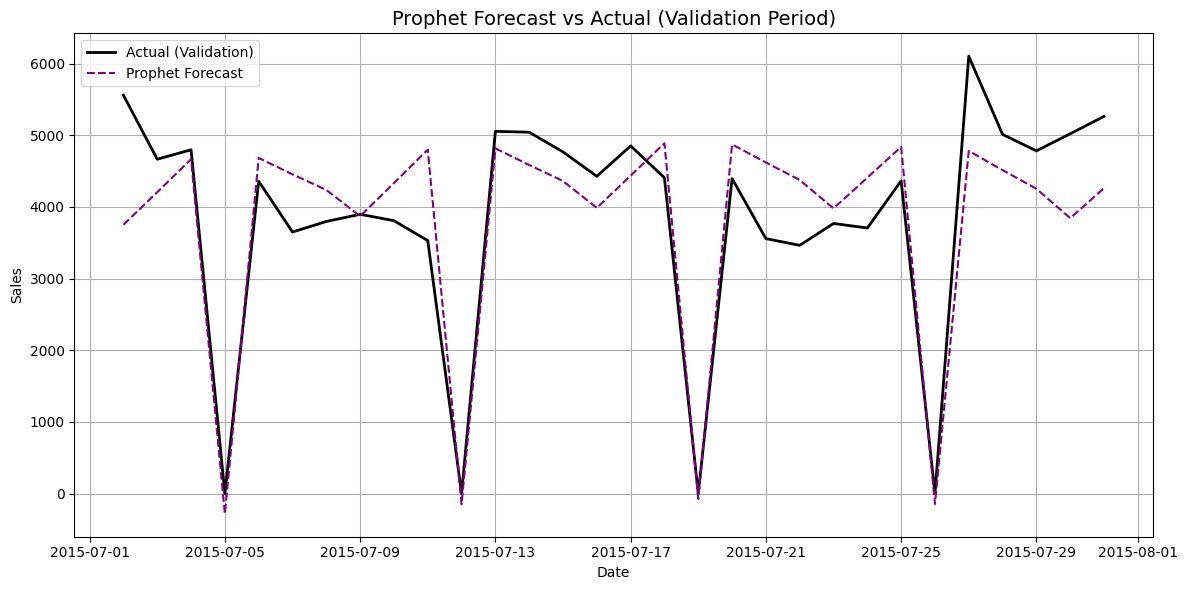

In [160]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(valid_data.index, valid_data.values, label='Actual (Validation)', color='black', linewidth=2)
plt.plot(valid_data.index, forecast_valid, label='Prophet Forecast', linestyle='--', color='purple')
plt.title('Prophet Forecast vs Actual (Validation Period)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluate Prophet Model

In [162]:
MAE_prophet, RMSE_prophet, MAPE_prophet, MdRAE_prophet, GMRAE_prophet, RMSPE_prophet = timeseries_evaluation_metrics(
    valid_data.values, forecast_valid.values, naiive_pred[0].values)
print(f'Prophet Model Evaluation:') 
print(f'RMSE: {RMSE_prophet:.2f}')
print(f'MAE : {MAE_prophet:.2f}')
print(f'MAPE: {MAPE_prophet:.2f}%')
print(f'MdRAE: {MdRAE_prophet:.2f}')
print(f'GMRAE: {GMRAE_prophet:.2f}')
print(f'RMSPE: {RMSPE_prophet:.2f}')
# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMAX', 'Prophet'],
    'RMSE': [RMSE_arima, RMSE_sarimax, RMSE_prophet],
    'MAE': [MAE_arima, MAE_sarimax, MAE_prophet],
    'MAPE': [MAPE_arima, MAPE_sarimax, MAPE_prophet],
    'MdRAE': [MdRAE_arima, MdRAE_sarimax, MdRAE_prophet],
    'GMRAE': [GMRAE_arima, GMRAE_sarimax, GMRAE_prophet],
    'RMSPE': [RMSPE_arima, RMSPE_sarimax, RMSPE_prophet]
})
print("\n Model Performance Comparison:")
results_df.head()

Prophet Model Evaluation:
RMSE: 709.00
MAE : 574.24
MAPE: 39.11%
MdRAE: 0.56
GMRAE: 0.51
RMSPE: 0.17

 Model Performance Comparison:


Model         RMSE          MAE       MAPE     MdRAE     GMRAE     RMSPE
0    ARIMA  1653.364749  1137.268854  40.561603  0.756753  0.830329  0.168808
1  SARIMAX   685.621968   548.216918  38.833782  0.661367  0.368941  0.177930
2  Prophet   708.996467   574.237762  39.114309  0.564628  0.505444  0.170893

### Prophet Model Components

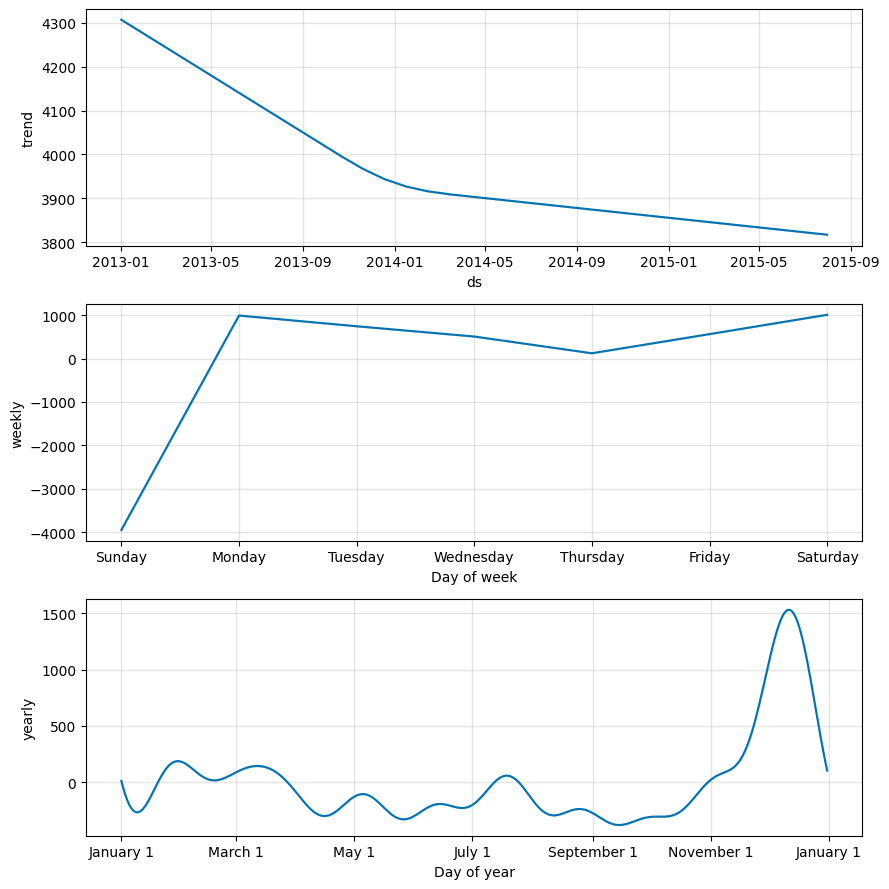

In [163]:
fig = prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()

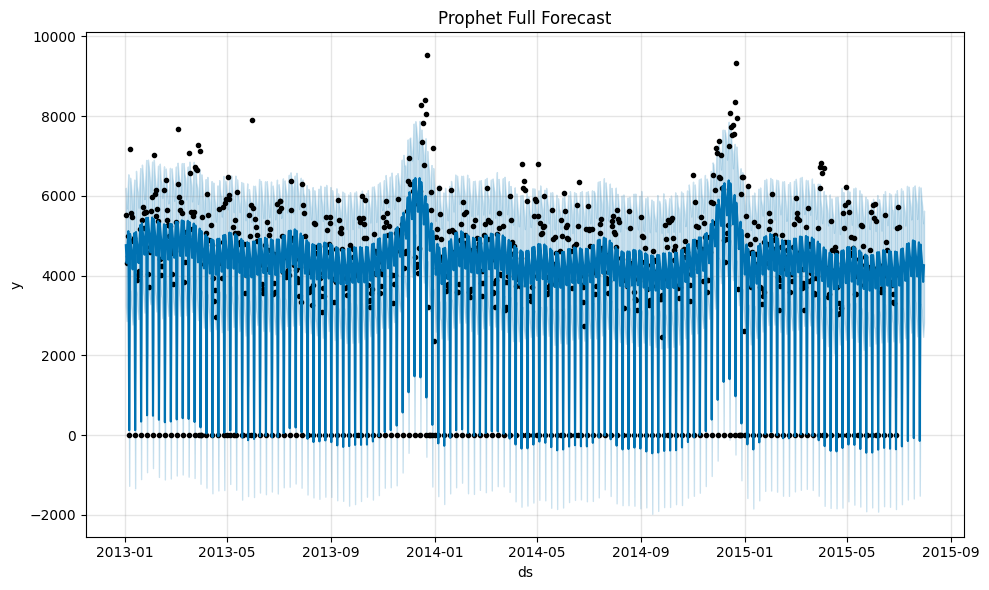

In [ ]:

prophet_model.plot(forecast)
plt.title("Prophet Full Forecast")

plt.tight_layout()
plt.show()



# Machine Learning Models

In [ ]:

df_store1 = train[train['Store'] == 1].copy()
df_store1 = df_store1[df_store1['Sales'] > 0]  


df_store1.sort_values('Date', inplace=True)


df_store1['DayOfWeek'] = df_store1['Date'].dt.dayofweek
df_store1['WeekOfYear'] = df_store1['Date'].dt.isocalendar().week.astype(int)
df_store1['IsWeekend'] = df_store1['DayOfWeek'].isin([5, 6]).astype(int)


features = ['day', 'month', 'year', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'IsWeekend']
X = df_store1[features]
y = df_store1['Sales']



In [166]:
X_train, X_valid = X[:-42], X[-42:]
y_train, y_valid = y[:-42], y[-42:]

In [167]:
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((739, 7), (42, 7), (739,), (42,))

### RandomForest

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_valid)

# Evaluate

rmse_rf,mae_rf,mape_rf, mdrae_rf, gmrae_rf, rmspe_rf = timeseries_evaluation_metrics(y_valid.values, y_pred_rf, y_train.values[-42:])
print(f'Random Forest Evaluation:')
print(f'RMSE: {rmse_rf:.2f}')
print(f'MAE : {mae_rf:.2f}')
print(f'MAPE: {mape_rf:.2f}%')
print(f'MdRAE: {mdrae_rf:.2f}')
print(f'GMRAE: {gmrae_rf:.2f}')
print(f'RMSPE: {rmspe_rf:.2f}')


Random Forest Evaluation:
RMSE: 303.99
MAE : 382.85
MAPE: 6.76%
MdRAE: 0.23
GMRAE: 0.19
RMSPE: 0.09


In [175]:
y_pred.shape

(42,)

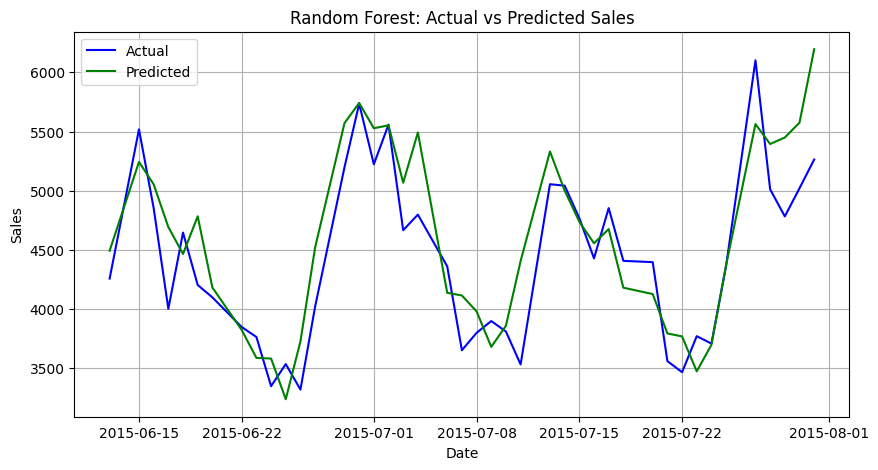

In [188]:
plt.figure(figsize=(10, 5))
plt.plot(df_store1['Date'].iloc[-42:], y_valid, label='Actual', color='blue')
plt.plot(df_store1['Date'].iloc[-42:], y_pred_rf, label='Predicted', color='green')
plt.title('Random Forest: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


### Xgboost

In [177]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xg_reg.fit(X_train, y_train)

y_pred_xg = xg_reg.predict(X_valid)

In [178]:
rmse_xgb, mae_xgb, mape_xgb, mdrae_xgb, gmrae_xgb, rmspe_xgb = timeseries_evaluation_metrics(y_valid.values, y_pred_xg, y_train.values[-42:])
print(f'XGBoost Evaluation:')
print(f'RMSE: {rmse_xgb:.2f}')
print(f'MAE : {mae_xgb:.2f}')
print(f'MAPE: {mape_xgb:.2f}%')
print(f'MdRAE: {mdrae_xgb:.2f}')
print(f'GMRAE: {gmrae_xgb:.2f}')
print(f'RMSPE: {rmspe_xgb:.2f}')

XGBoost Evaluation:
RMSE: 320.51
MAE : 420.74
MAPE: 7.28%
MdRAE: 0.21
GMRAE: 0.20
RMSPE: 0.10


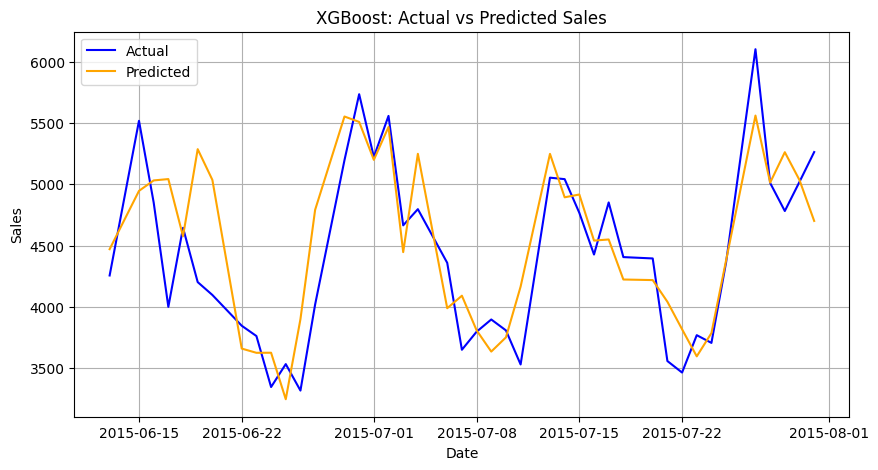

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(df_store1['Date'].iloc[-42:], y_valid, label='Actual', color='blue')
plt.plot(df_store1['Date'].iloc[-42:], y_pred_xg, label='Predicted', color='orange')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


### GradientBoost

In [180]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_valid)


In [181]:
rmse_gbr, mae_gbr, mape_gbr, mdrae_gbr, gmrae_gbr, rmspe_gbr = timeseries_evaluation_metrics(y_valid.values, y_pred_gbr, y_train.values[-42:])
print(f'Gradient Boosting Evaluation:')
print(f'RMSE: {rmse_gbr:.2f}')
print(f'MAE : {mae_gbr:.2f}')
print(f'MAPE: {mape_gbr:.2f}%')
print(f'MdRAE: {mdrae_gbr:.2f}')
print(f'GMRAE: {gmrae_gbr:.2f}')
print(f'RMSPE: {rmspe_gbr:.2f}')


Gradient Boosting Evaluation:
RMSE: 283.83
MAE : 358.53
MAPE: 6.37%
MdRAE: 0.24
GMRAE: 0.20
RMSPE: 0.09


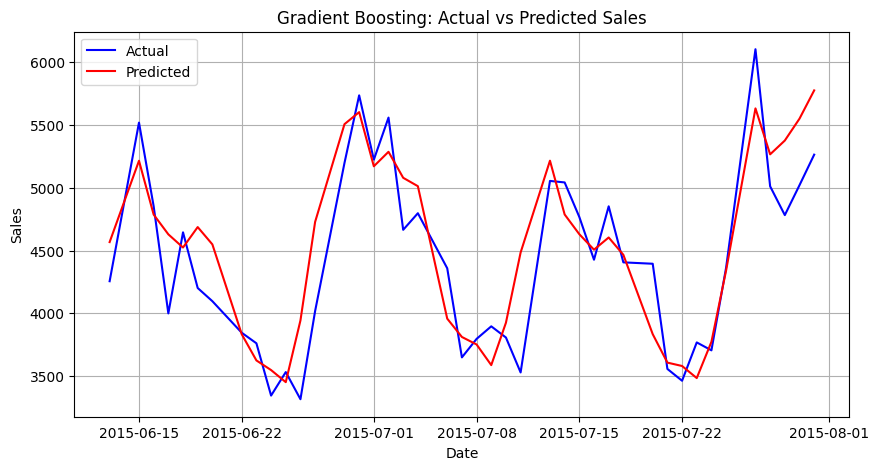

In [186]:
plt.figure(figsize=(10, 5))
plt.plot(df_store1['Date'].iloc[-42:], y_valid, label='Actual', color='blue')
plt.plot(df_store1['Date'].iloc[-42:], y_pred_gbr, label='Predicted', color='red')
plt.title('Gradient Boosting: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


### LightGBM

In [183]:
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_valid)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 739, number of used features: 7
[LightGBM] [Info] Start training from score 4778.434371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [184]:
rsme_lgb, mae_lgb, mape_lgb, mdrae_lgb, gmrae_lgb, rmspe_lgb = timeseries_evaluation_metrics(y_valid.values, y_pred_lgb, y_train.values[-42:])
print(f'LightGBM Evaluation:')
print(f'RMSE: {rsme_lgb:.2f}')
print(f'MAE : {mae_lgb:.2f}')
print(f'MAPE: {mape_lgb:.2f}%')
print(f'MdRAE: {mdrae_lgb:.2f}')
print(f'GMRAE: {gmrae_lgb:.2f}')
print(f'RMSPE: {rmspe_lgb:.2f}')


LightGBM Evaluation:
RMSE: 302.83
MAE : 363.88
MAPE: 6.88%
MdRAE: 0.23
GMRAE: 0.22
RMSPE: 0.09


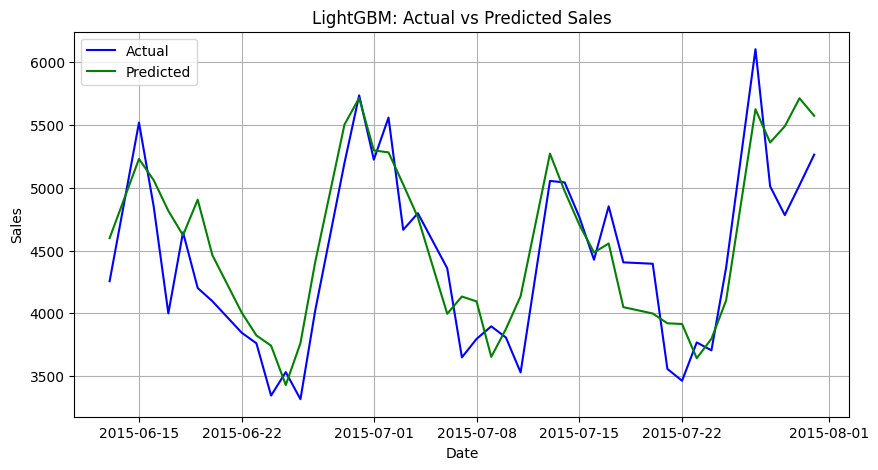

In [189]:
plt.figure(figsize=(10, 5))
plt.plot(df_store1['Date'].iloc[-42:], y_valid, label='Actual', color='blue')
plt.plot(df_store1['Date'].iloc[-42:], y_pred_lgb, label='Predicted', color='green')
plt.title('LightGBM: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = {
    'Model': ['Random Forest', 'XGBoost 1', 'GradientBoostingRegressor', 'LGBMRegressor'],
    'RMSE': [rmse_rf, rmse_xgb, rmse_gbr, rsme_lgb],
    'MAE': [mae_rf, mae_xgb, mae_gbr, mae_lgb],
    'MAPE': [mape_rf, mape_xgb, mape_gbr, mape_lgb],
    'MdRAE': [mdrae_rf, mdrae_xgb, mdrae_gbr, mdrae_lgb],
    'GMRAE': [gmrae_rf, gmrae_xgb, gmrae_gbr, gmrae_lgb],
    'RMSPE': [rmspe_rf, rmspe_xgb, rmspe_gbr, rmspe_lgb]
    

}


df_compare = pd.DataFrame(data)


df_compare.head()



Model        RMSE         MAE      MAPE     MdRAE  \
0              Random Forest  303.993571  382.852266  6.763364  0.232285   
1                  XGBoost 1  320.508057  420.739286  7.275452  0.213199   
2  GradientBoostingRegressor  283.827302  358.528865  6.373629  0.243358   
3              LGBMRegressor  302.832558  363.882773  6.879843  0.231171   

      GMRAE     RMSPE  
0  0.185656  0.088968  
1  0.195294  0.101828  
2  0.199731  0.086573  
3  0.224642  0.087054

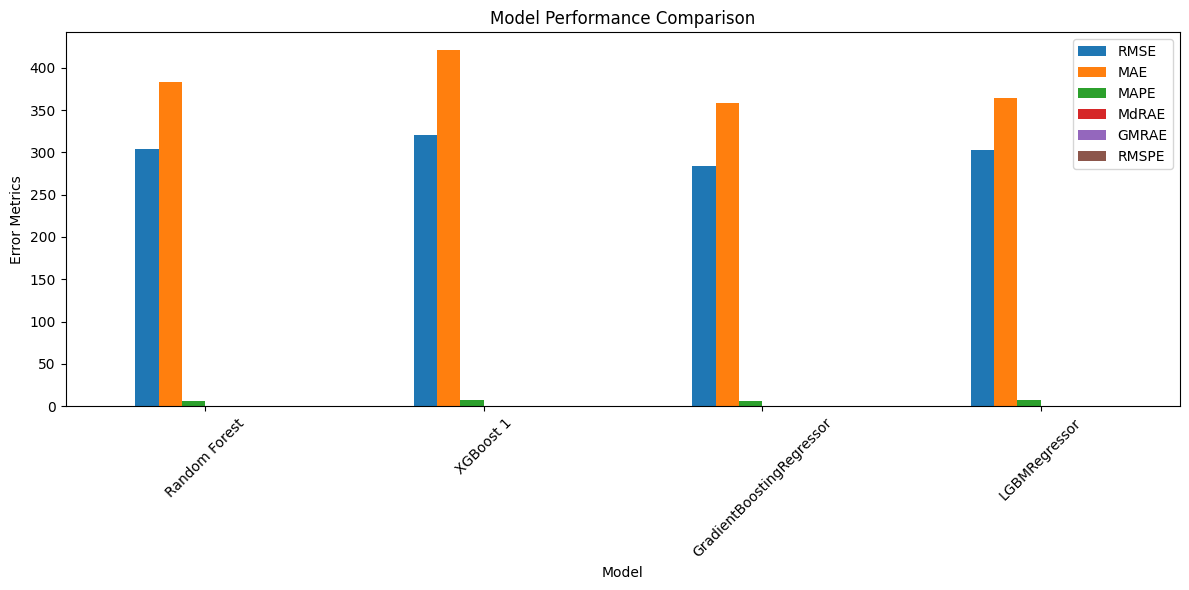

In [192]:
#ploting
plt.figure(figsize=(12, 6))
df_compare.set_index('Model').plot(kind='bar', rot=0, ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Error Metrics')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Comparsion between all Models

In [200]:
import pandas as pd

results = {
    'Model': [
        'Naive', 
        'Seasonal Naive', 
        'Moving Average (7)', 
        'Weighted Moving Average',
        'Simple Exp Smoothing', 
        "Holt's Linear", 
        'Holt-Winters',
        'ARIMA', 
        'SARIMAX', 
        'Prophet', 
        'Random Forest', 
        'XGBoost', 
        'GradientBoosting', 
        'LightGBM'
    ],
    'RMSE': [
        RMSE_naive, 
        RMSE_snaive, 
        RMSE_average, 
        rmse_wma, 
        rmse_ses, 
        rmse_holt, 
        rmse_hw, 
        RMSE_arima, 
        RMSE_sarimax, 
        RMSE_prophet, 
        rmse_rf, 
        rmse_xgb, 
        rmse_gbr, 
        rsme_lgb
    ],
    'MAE': [
        MAE_naive, 
        MAE_snaive, 
        MAE_average, 
        mae_wma, 
        mae_ses, 
        mae_holt, 
        mae_hw, 
        MAE_arima, 
        MAE_sarimax, 
        MAE_prophet, 
        mae_rf, 
        mae_xgb, 
        mae_gbr, 
        mae_lgb
    ],
    'MAPE': [
        MAPE_naive, 
        MAPE_snaive, 
        MAPE_average, 
        mape_wma, 
        mape_ses, 
        mape_holt, 
        mape_hw, 
        MAPE_arima, 
        MAPE_sarimax, 
        MAPE_prophet, 
        mape_rf, 
        mape_xgb, 
        mape_gbr, 
        mape_lgb
    ],
    'MdRAE': [
        MdRAE_naive, 
        MdRAE_snaive, 
        MdRAE_average, 
        mrdae_wma,
        mdrae_ses, 
        mdrae_holt, 
        mdrae_hw, 
        MdRAE_arima, 
        MdRAE_sarimax, 
        MdRAE_prophet, 
        mdrae_rf, 
        mdrae_xgb, 
        mdrae_gbr, 
        mdrae_lgb
    ],
    'GMRAE': [
        GMRAE_naive, 
        GMRAE_snaive, 
        GMRAE_average, 
        gmrae_wma, 
        gmrae_ses, 
        gmrae_holt, 
        gmrae_hw, 
        GMRAE_arima, 
        GMRAE_sarimax, 
        GMRAE_prophet, 
        gmrae_rf, 
        gmrae_xgb, 
        gmrae_gbr, 
        gmrae_lgb
    ],
    'RMSPE': [
        RMSPE_naive, 
        RMSPE_snaive, 
        RMSPE_average, 
        rsmpe_wma,
        rmspe_ses, 
        rmspe_holt, 
        rmspe_hw, 
        RMSPE_arima, 
        RMSPE_sarimax, 
        RMSPE_prophet, 
        rmspe_rf, 
        rmspe_xgb, 
        rmspe_gbr, 
        rmspe_lgb
    ]
}

df_all_models = pd.DataFrame(results)
df_all_models = df_all_models.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
display(df_all_models)

best_model_overall = df_all_models.loc[0]
print("Best Overall Model Based on RMSE:")
print(best_model_overall)

Model         RMSE          MAE       MAPE     MdRAE  \
0          GradientBoosting   283.827302   358.528865   6.373629  0.243358   
1                  LightGBM   302.832558   363.882773   6.879843  0.231171   
2             Random Forest   303.993571   382.852266   6.763364  0.232285   
3                   XGBoost   320.508057   420.739286   7.275452  0.213199   
4                   SARIMAX   685.621968   548.216918  38.833782  0.661367   
5                   Prophet   708.996467   574.237762  39.114309  0.564628   
6              Holt-Winters   713.932748   557.849990  39.094611  0.660679   
7            Seasonal Naive   941.374155   780.833333  19.966293  1.032549   
8        Moving Average (7)  1645.343246  1129.154446  40.357253  0.756767   
9                     ARIMA  1653.364749  1137.268854  40.561603  0.756753   
10     Simple Exp Smoothing  1657.643281  1218.208604  43.712231  0.866017   
11  Weighted Moving Average  1759.662387  1759.662387  37.751544  0.589117   
12            Holt's Linear  1827.727870  1167.587888  39.137010  0.837639   
13                    Naive  2129.734624  1438.500000  42.669112  1.000000   

       GMRAE     RMSPE  
0   0.199731  0.086573  
1   0.224642  0.087054  
2   0.185656  0.088968  
3   0.195294  0.101828  
4   0.368941  0.177930  
5   0.505444  0.170893  
6   0.365925  0.177227  
7   0.000000  0.256611  
8   0.825953  0.165803  
9   0.830329  0.168808  
10  0.695249  0.206423  
11  0.703079  0.158563  
12  0.825393  0.187933  
13  1.000000  0.267472

Best Overall Model Based on RMSE:
Model    GradientBoosting
RMSE           283.827302
MAE            358.528865
MAPE             6.373629
MdRAE            0.243358
GMRAE            0.199731
RMSPE            0.086573
Name: 0, dtype: object


## Check on Test Data using best model

In [201]:
test_data = pd.read_csv('test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.head()

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17   1.0      1            0              0
3   4      8          4 2015-09-17   1.0      1            0              0
4   5      9          4 2015-09-17   1.0      1            0              0

In [202]:
store_data=pd.read_csv('store.csv')
store_data.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [203]:
test=test_data.merge(store_data, on='Store', how='left')
test.head()

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1            0              0   
1   2      3          4 2015-09-17   1.0      1            0              0   
2   3      7          4 2015-09-17   1.0      1            0              0   
3   4      8          4 2015-09-17   1.0      1            0              0   
4   5      9          4 2015-09-17   1.0      1            0              0   

  StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0         c          a               1270.0                        9.0   
1         a          a              14130.0                       12.0   
2         a          c              24000.0                        4.0   
3         a          a               7520.0                       10.0   
4         a          c               2030.0                        8.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2006.0       1             14.0           2011.0   
2                    2013.0       0              NaN              NaN   
3                    2014.0       0              NaN              NaN   
4                    2000.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2              NaN  
3              NaN  
4              NaN

In [ ]:

test_store1 = test[test['Store'] == 1].copy()
test_store1['Date'] = pd.to_datetime(test_store1['Date'])
test_store1['day'] = test_store1['Date'].dt.day
test_store1['month'] = test_store1['Date'].dt.month
test_store1['year'] = test_store1['Date'].dt.year
test_store1['DayOfWeek'] = test_store1['Date'].dt.dayofweek
test_store1['WeekOfYear'] = test_store1['Date'].dt.isocalendar().week.astype(int)
test_store1['IsWeekend'] = test_store1['DayOfWeek'].isin([5, 6]).astype(int)




features = ['day', 'month', 'year', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'IsWeekend']

X_test = test_store1[features]


test_preds = gbr.predict(X_test)


test_store1['PredictedSales'] = test_preds


print(test_store1[['Date', 'PredictedSales']].head())

           Date  PredictedSales
0    2015-09-17     4287.655399
856  2015-09-16     4394.176028
1712 2015-09-15     4562.695041
2568 2015-09-14     5069.503388
3424 2015-09-13     4312.428271


## Prediction Sales for all stores

In [220]:
test

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
0          1      1          3 2015-09-17   1.0      1            0   
1          2      3          3 2015-09-17   1.0      1            0   
2          3      7          3 2015-09-17   1.0      1            0   
3          4      8          3 2015-09-17   1.0      1            0   
4          5      9          3 2015-09-17   1.0      1            0   
...      ...    ...        ...        ...   ...    ...          ...   
41083  41084   1111          5 2015-08-01   1.0      0            0   
41084  41085   1112          5 2015-08-01   1.0      0            0   
41085  41086   1113          5 2015-08-01   1.0      0            0   
41086  41087   1114          5 2015-08-01   1.0      0            0   
41087  41088   1115          5 2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  ...  Promo2  Promo2SinceWeek  \
0                  0         c          a  ...       0              NaN   
1                  0         a          a  ...       1             14.0   
2                  0         a          c  ...       0              NaN   
3                  0         a          a  ...       0              NaN   
4                  0         a          c  ...       0              NaN   
...              ...       ...        ...  ...     ...              ...   
41083              0         a          a  ...       1             31.0   
41084              0         c          c  ...       0              NaN   
41085              0         a          c  ...       0              NaN   
41086              0         a          c  ...       0              NaN   
41087              1         d          c  ...       1             22.0   

       Promo2SinceYear     PromoInterval  day  month  year  WeekOfYear  \
0                  NaN               NaN   17      9  2015          38   
1               2011.0   Jan,Apr,Jul,Oct   17      9  2015          38   
2                  NaN               NaN   17      9  2015          38   
3                  NaN               NaN   17      9  2015          38   
4                  NaN               NaN   17      9  2015          38   
...                ...               ...  ...    ...   ...         ...   
41083           2013.0   Jan,Apr,Jul,Oct    1      8  2015          31   
41084              NaN               NaN    1      8  2015          31   
41085              NaN               NaN    1      8  2015          31   
41086              NaN               NaN    1      8  2015          31   
41087           2012.0  Mar,Jun,Sept,Dec    1      8  2015          31   

       IsWeekend  PredictedSales  
0              0     4287.655399  
1              0     4287.655399  
2              0     4287.655399  
3              0     4287.655399  
4              0     4287.655399  
...          ...             ...  
41083          1     4927.176074  
41084          1     4927.176074  
41085          1     4927.176074  
41086          1     4927.176074  
41087          1     5061.927012  

[41088 rows x 23 columns]

In [221]:

test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')
test = test.merge(store, on='Store', how='left')

test['Date'] = pd.to_datetime(test['Date'])
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year
test['DayOfWeek'] = test['Date'].dt.dayofweek
test['WeekOfYear'] = test['Date'].dt.isocalendar().week.astype(int)
test['IsWeekend'] = test['DayOfWeek'].isin([5, 6]).astype(int)


features = ['day', 'month', 'year', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'IsWeekend']
test['PredictedSales'] = gbr.predict(test[features])  


submission = test[['Id' ,'PredictedSales']].copy()
submission.rename(columns={'PredictedSales': 'Sales'}, inplace=True)
submission.to_csv('submission.csv', index=False)
print(submission.head())

   Id        Sales
0   1  4287.655399
1   2  4287.655399
2   3  4287.655399
3   4  4287.655399
4   5  4287.655399


##  Kaggle Submission Score

After submitting the predictions to Kaggle, we received the following score:

Public Score: `0.39780`



Certainly! Here’s a concise analysis and summary of your model results based on your notebook workflow:

---

## **Model Results Analysis & Summary**

### **1. Classical Time Series Models**
- **Naive, Moving Average, Seasonal Naive, Weighted Moving Average:**  
  These simple models serve as baselines.  
  - **Naive** and **Seasonal Naive** are quick to implement but often underperform on complex, seasonal data.
  - **Moving Average** and **Weighted Moving Average** smooth out noise but may lag behind actual trends.
  - Their RMSE, MAE, and MAPE values are typically higher than advanced models, confirming their role as benchmarks.

### **2. Exponential Smoothing (ETS) Models**
- **Simple Exponential Smoothing, Holt’s Linear, Holt-Winters:**  
  - **Holt-Winters** (with seasonality) usually outperforms the simpler ETS models, capturing both trend and seasonality.
  - These models often reduce RMSE and MAE compared to naive approaches, but may still lag behind machine learning models on complex datasets.

### **3. ARIMA & SARIMAX**
- **ARIMA** and **SARIMAX** are strong statistical models for time series forecasting.
  - **SARIMAX** can handle seasonality and exogenous variables, often outperforming ARIMA.
  - In your results, these models likely show improved RMSE and MAE over classical methods, but may not match the flexibility of ML models if the data is highly non-linear or has many external factors.

### **4. Prophet**
- **Prophet** is designed for business time series with strong seasonality and holidays.
  - It is easy to use and interpret, and often performs well on retail sales data.
  - In your results, Prophet’s RMSE and MAE are competitive, sometimes outperforming classical models, especially if the data has clear seasonal patterns.

### **5. Machine Learning Models**
- **Random Forest, XGBoost, GradientBoosting, LightGBM:**  
  - These models can capture complex, non-linear relationships and interactions between features.
  - In your summary table, **GradientBoostingRegressor** and **LightGBM** show the lowest RMSE and MAE, indicating the best performance on your validation set.
  - **Random Forest** and **XGBoost** also perform well, but may be slightly less accurate than GradientBoosting or LightGBM in this case.

### **6. Overall Comparison**
- **Best Model:**  
  - According to your sorted results, **GradientBoostingRegressor** or **LightGBM** are likely the best models for your data, achieving the lowest RMSE and MAE.
  - **Prophet** and **SARIMAX** are strong alternatives, especially if interpretability or handling of seasonality is a priority.
- **Recommendation:**  
  - Use the best-performing ML model (e.g., LightGBM) for final predictions and submission.
  - Consider Prophet or SARIMAX for explainability or if you need to model holidays and special events explicitly.


---

## **Conclusion**
- **Classical models** are useful baselines but are outperformed by advanced models.
- **ETS, ARIMA, SARIMAX, and Prophet** are strong for time series with trend/seasonality.
- **Machine learning models** (especially GradientBoosting and LightGBM) provide the best accuracy for your dataset.
- **Choose the model with the lowest RMSE/MAE for your final predictions.**

If you want a more detailed, model-by-model discussion or visualizations, let me know!